<a href="https://colab.research.google.com/github/karthikmnkrishna/Loan-default-prediction/blob/Build-Phase-2/Lending_case_Study_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club Case Study

## Import Libraries

In [1620]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import re
sns.set(style='whitegrid')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [1621]:
path = '/content/drive/My Drive/Masters/loan.csv'
loans = pd.read_csv(path)
print(loans.shape)

(39717, 111)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [1622]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


**Info Summary:**
1. There are 39717 enteries (rows of data)
2. 111 columns of which 74 of them are float type, 13 are integer type and 24 are object type. (But there could be some date type, which is to be checked)
3. Column 47 has mixed type as per the warning above, need to be analyzed further later


**Data Clean up**
1. remove all invalid rows (rows which has all column enteries which are NAN)
2. remove all invalid columns (columns which has all row enteries which are NAN)
3. remove all numeric data elements where there is no change in data 
4. remove all string/object columns where data elements are same
5. convert all columns where date type is present to datetime type

### 1. remove all invalid rows 

Remove all the rows which has all column enteries which are NAN

In [1623]:
loans.dropna(axis=0, how='all', inplace=True)

### 2. remove all invalid columns 

Remove all columns which has all row enteries which are NAN

In [1624]:
loans.dropna(axis=1, how='all', inplace=True)

In [1625]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

From above it is clear that more than 50% of the columns did not have data and cannot be used for analysis, But number of data elements(rows or indexes) though has remained same which means we did not have any invalid data points

### 3. remove all columns where there is no variation in data 

There are multiple ways how we can remove the data elements. 
For numeric data we can check for standard deviation to be zero
Check for unique value counts in all columns and if the number of unique values is one, we can drop that columns

In [1626]:
loans.drop(loans.loc[:,loans.nunique() == 1].columns, inplace=True, axis=1)

In [1627]:
loans.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 0 to 39716
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

There were 9 columns where there were no variation in numeric data(standard deviation is zero) and no change in string data, which are removed

### 4. Convert all the date columns from string to datetime format

In [1628]:
import datetime
updateNaT = lambda x : datetime.date(9999, 12,31) if pd.isnull(x) else x

In [1629]:
dateColumns = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']

In [1630]:
for col in dateColumns:
  loans[col] = pd.to_datetime(loans[col], format="%b-%y").apply(updateNaT)

**earliest_cr_line** column has mixed date time type

In [1631]:
earliest_cr_line_data = loans['earliest_cr_line']
# earliest_cr_line_data = pd.to_datetime(earliest_cr_line_data, format="%b-%y", errors='ignore')

In [1632]:
earliest_cr_line_data.head()

0    Jan-85
1    Apr-99
2    Nov-01
3    Feb-96
4    Jan-96
Name: earliest_cr_line, dtype: object

### Clean up column mths_since_last_delinq

Fill value -1 for invalid data

In [1633]:
loans.mths_since_last_delinq.fillna(value=-1, inplace=True)
loans.mths_since_last_delinq = loans.mths_since_last_delinq.astype(int)

### clean up column mths_since_last_record

In [1634]:
loans.mths_since_last_record.fillna(value=-1, inplace=True)
loans.mths_since_last_record = loans.mths_since_last_record.astype(int)

### Clean up int_rate column

The interest rate column is a string column, which is to be converted to numeric for better analysis.</br>
int_rate column ends with '%' which is to be stripped

In [1635]:
loans.int_rate = loans.int_rate.apply(lambda x : float(x[:-1]))

### Clean up revol_util column

The revol_util column also is a string column and ends with '%'. It should be converted into numeric column and invalid columns are to be filled with -1

In [1636]:
loans.revol_util.fillna(value='-1%', inplace=True)
loans.revol_util = list(map(lambda x : float(x[:-1]), loans.revol_util.values))

### Clean up **desc** column

In [1637]:
loans.desc.fillna(' ' ,inplace= True)
loans['desc'] = loans.desc.str.replace('<br>' , '')
loans['desc'] = loans.desc.str.replace('Borrower added on ' , '')
loans['desc'] = loans.desc.str.replace('(1[0-2]|0[1-9])/(3[01]|[12][0-9]|0[1-9])/(1[0-2]|0[1-9])' , '')
loans['desc'] = loans.desc.str.replace('>' ,'')

### clean up **emp_title** column

The emp_title column where the data is not present can be updated with value of 'Not Given'

In [1638]:
loans.emp_title.fillna('Not Given' ,inplace= True)

### clean up **emp_length** column

The invalid enteries of the column is updated with 'Not Given'

In [1639]:
loans.emp_length.fillna('Not Given' ,inplace= True)

### clean up **title** & **terms** column

In [1640]:
loans.title.fillna('Not Specified', inplace=True)
loans['term']= loans.term.str.strip()

### Clean up pub_rec_bankruptcies column

In [1641]:
#loans.pub_rec_bankruptcies.fillna(-1.0, inplace=True)
loans =loans[~(loans.pub_rec_bankruptcies.isna())]

### Handling id, member id and url

In [1642]:
loans.agg(['count', 'nunique']).transpose()

,count,nunique
id,39020,39020
member_id,39020,39020
loan_amnt,39020,876
funded_amnt,39020,1035
funded_amnt_inv,39020,7869
term,39020,2
int_rate,39020,337
installment,39020,14993
grade,39020,7
sub_grade,39020,35


The columns **id**, **member_id** and **url** have all the columns values being unique. <br>
So we can easily drop two of the three columns and set one as the index. <br>
So we will retain only **id** column and drop the other two

In [1643]:
loans.set_index('id', inplace=True)
loans.drop(columns=['member_id', 'url'], inplace=True)

### Removing columns by observation

From the info earlier, we saw that column **next_pymnt_d** has very less data(1140), but let us plot the payment_status and then conclude

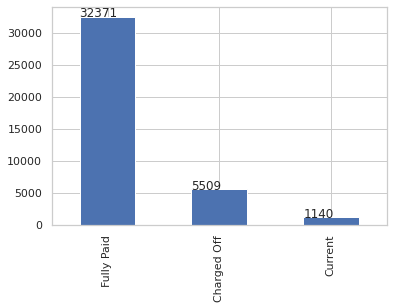

In [1644]:
ax = loans.loan_status.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

From the plot above we can see that, the number of loans with status **Current** is equal to 1140 which is exactly the number of data points in column **next_pymnt_d**

In [1645]:
loans[loans.loan_status == 'Current']['next_pymnt_d'].unique()

array([Timestamp('2016-06-01 00:00:00'), Timestamp('2016-07-01 00:00:00')],
      dtype=object)

Since there are only two values and may not be very interesting to analyze, we will delete the column

In [1646]:
loans.drop(columns=['next_pymnt_d'], inplace=True)

### Final Data Check

In [1647]:
loans.isna().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
desc                       0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_in

Since there are no null columns, missing data is added with default values/ invalid value indicators

## Outlier Analysis

Let us get use the describe function to get the stats of all the numeric columns

In [1648]:
loans.describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90]).transpose()

,count,mean,std,min,10%,25%,50%,75%,90%,max
loan_amnt,39020.0,11242.004741,7472.992773,500.00,3200.000000,5500.000000,10000.000000,15000.000000,22000.000,3.500000e+04
funded_amnt,39020.0,10967.680677,7200.731107,500.00,3200.000000,5400.000000,9650.000000,15000.000000,21000.000,3.500000e+04
funded_amnt_inv,39020.0,10541.094952,7104.340838,0.00,3000.000000,5000.000000,9000.000000,14475.000000,20000.000,3.500000e+04
int_rate,39020.0,12.045844,3.743006,5.42,7.140000,9.250000,11.860000,14.610000,17.060,2.459000e+01
installment,39020.0,324.602306,208.860351,16.08,99.630000,167.132500,280.020000,430.780000,622.130,1.305190e+03
annual_inc,39020.0,68958.646129,63155.937917,4000.00,30000.000000,40800.000000,59000.000000,82404.000000,116000.000,6.000000e+06
dti,39020.0,13.359369,6.670254,0.00,4.150000,8.230000,13.450000,18.630000,22.360,2.999000e+01
delinq_2yrs,39020.0,0.145618,0.490474,0.00,0.000000,0.000000,0.000000,0.000000,1.000,1.100000e+01
inq_last_6mths,39020.0,0.866658,1.067222,0.00,0.000000,0.000000,1.000000,1.000000,2.000,8.000000e+00
mths_since_last_delinq,39020.0,12.025679,21.984374,-1.00,-1.000000,-1.000000,-1.000000,21.000000,48.000,1.200000e+02


The describe function gives a good overview for all the numeric variables, But each has to be analyzed individually to understand and remove outliers better

### annual_inc

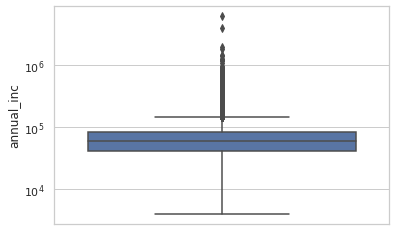

In [1649]:
sns.boxplot(y='annual_inc', data=loans)
plt.yscale('log')

In [1650]:
quantileRange = [0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99,1]

In [1651]:
loans.annual_inc.quantile(quantileRange)

0.000    4000.000   
0.001    8502.432   
0.010    14400.000  
0.025    19200.000  
0.050    24000.000  
0.100    30000.000  
0.250    40800.000  
0.500    59000.000  
0.750    82404.000  
0.975    175000.000 
0.990    234486.000 
1.000    6000000.000
Name: annual_inc, dtype: float64

So from the above box plot and values, we can see that there are outliers present in the dataset, so let us take 99% of the data and rest can be left out

In [1652]:
loans = loans[loans.annual_inc.between(loans.annual_inc.quantile(0), loans.annual_inc.quantile(.99))]

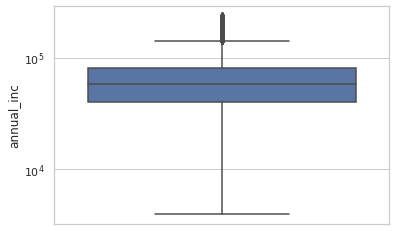

In [1653]:
sns.boxplot(y='annual_inc', data=loans)
plt.yscale('log')

Now the outliers in annual_inc is removed

### loan_amnt

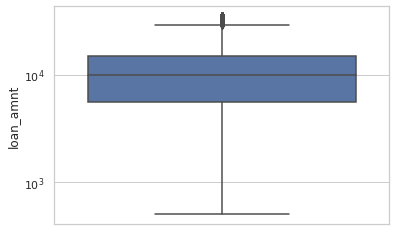

In [1654]:
sns.boxplot(y='loan_amnt', data=loans)
plt.yscale('log')

In [1655]:
loans.loan_amnt.quantile(quantileRange)

0.000    500.0  
0.001    1000.0 
0.010    1200.0 
0.025    1700.0 
0.050    2400.0 
0.100    3200.0 
0.250    5500.0 
0.500    10000.0
0.750    15000.0
0.975    30000.0
0.990    35000.0
1.000    35000.0
Name: loan_amnt, dtype: float64

There are not many outliers in the loan_amnt, so this column can be used as it is

### installment

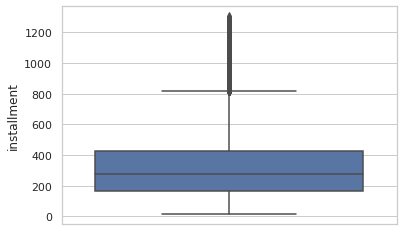

In [1656]:
sns.boxplot(y='installment', data=loans)

In [1657]:
loans.installment.quantile(quantileRange)

0.000    16.080  
0.001    30.160  
0.010    37.754  
0.025    52.939  
0.050    71.110  
0.100    99.450  
0.250    166.510 
0.500    278.830 
0.750    426.100 
0.975    843.080 
0.990    921.600 
1.000    1305.190
Name: installment, dtype: float64

### dti

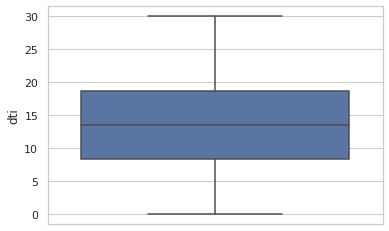

In [1658]:
sns.boxplot(y='dti', data=loans)

Clear from boxplot, that there is no outlier

### total_pymnt

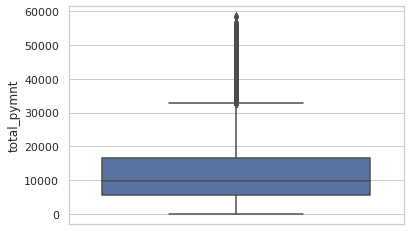

In [1659]:
sns.boxplot(y='total_pymnt', data=loans)

In [1660]:
loans.total_pymnt.quantile(quantileRange)

0.000    0.000000    
0.001    95.386440   
0.010    759.759600  
0.025    1241.802703 
0.050    1877.978072 
0.100    2957.116000 
0.250    5566.668542 
0.500    9855.228630 
0.750    16455.080000
0.975    35148.174996
0.990    41868.726554
1.000    58563.679930
Name: total_pymnt, dtype: float64

No outliers found

## UNIVARIATE/SEGMENTED UNIVARIATE ANALYSIS

#### Helper functions

##### count plot

In [1661]:
def get_totals_count(ax):

    heights = [x.get_height() for x in ax.patches]
    return sum(heights)

In [1662]:
def plot_count_chart(ColdataSeries, figsize=(20,10), logScale=False, isPercentage=True):
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=ColdataSeries)
    
    plt.tight_layout()
    patch_totals = get_totals_count(ax)
    for p in ax.patches:
      if isPercentage:
        ax.annotate('{:.2f}% ({})'.format(p.get_height()*100/patch_totals, 
                                          int(p.get_height())),
                    (p.get_x() * 1.005, p.get_height() * 1.005))
      else:
        ax.annotate('{}'.format(int(p.get_height())),
                    (p.get_x() * 1.005, p.get_height() * 1.005))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    if logScale:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()

##### Rank-Frequency Plot

In [1663]:
def plot_rank_frequency(ColdataSeries, dataColumnName):
    sns.set(style="whitegrid")
    data = pd.DataFrame({'Frequency' : ColdataSeries.value_counts() })
    data['rank'] = data.rank(ascending=False)
    plt.title("Rank - Frequency plot for {}".format(dataColumnName))
    plt.ylabel("Frequency")
    plt.xlabel("Rank")
    plt.loglog(data['rank'], data['Frequency'], basex=10)

### Bar Plot with Table


In [1664]:
def bar_plot( x,y ,data ,title = '',sizerow=10 , sizecolumn =10 ,tabletoggle =True , axistoggle = 'off', logScale=False ):
  ax = data.groupby([x,y]).size().unstack().plot(kind='bar',stacked=True,figsize=(sizerow , sizecolumn),table = tabletoggle )
  plt.axis(axistoggle)
  plt.tight_layout()
  plt.title(title)
  if logScale:
        plt.yscale('log')
  plt.show()


##### Distribution Plot

In [1665]:
# to plot continuous data
def plot_distPlot(dataSeries, xLabel, yLabel='Count', bins=10,logScale=False, fontsize=15, figsize=(4,3)):
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    ax = sns.distplot(dataSeries, kde=False, color='green', bins=bins)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.xlabel(xLabel, fontsize=fontsize)
    plt.ylabel(yLabel,fontsize=fontsize)
    if logScale:
        plt.yscale('log')

##### Group Plot

In [1666]:
def plot_groupPlot(dataframe, index:list, columns, logScale=False, figsize=(4,3)):
    dataframe.pivot_table(index=index, columns=columns, aggfunc='size', fill_value=0).plot(kind='bar',figsize=figsize, 
                                                                                           logy=logScale)

###Distribution

Lets understand  the data we have using median , mode ,standard deviation etc.<br> 
Lets also observe the spread of data for some key features.

In [1667]:
loans.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000,38629.000000
mean,11156.076393,10885.087628,10462.025613,12.030387,322.035610,65566.588630,13.419974,0.144658,0.864532,12.024179,4.032385,9.273551,0.055813,13161.315152,48.877185,22.059463,51.634087,51.392116,12085.233650,11629.102640,9734.658470,2254.655861,1.324333,94.595066,12.016156,2671.817372,0.043594
std,7391.957184,7121.589708,7025.917199,3.735543,206.161625,35154.158509,6.655421,0.488970,1.065185,21.993240,21.674993,4.372438,0.238631,15402.523501,28.317915,11.353798,374.812485,373.455194,8958.998690,8821.333007,7000.263446,2588.141989,7.127483,684.804789,145.105776,4418.981698,0.205079
min,500.000000,500.000000,0.000000,5.420000,16.080000,4000.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5500.000000,5375.000000,5000.000000,9.250000,166.510000,40044.000000,8.320000,0.000000,0.000000,-1.000000,-1.000000,6.000000,0.000000,3699.000000,25.500000,14.000000,0.000000,0.000000,5566.668542,5270.250000,4530.770000,660.260000,0.000000,0.000000,0.000000,218.800000,0.000000
50%,10000.000000,9600.000000,9000.000000,11.860000,278.830000,58106.000000,13.510000,0.000000,1.000000,-1.000000,-1.000000,9.000000,0.000000,8813.000000,49.400000,20.000000,0.000000,0.000000,9855.228630,9398.350000,8000.000000,1343.280000,0.000000,0.000000,0.000000,546.620000,0.000000
75%,15000.000000,15000.000000,14400.000000,14.590000,426.100000,81000.000000,18.680000,0.000000,1.000000,21.000000,-1.000000,12.000000,0.000000,16902.000000,72.400000,29.000000,0.000000,0.000000,16455.080000,15829.710000,13500.000000,2827.210000,0.000000,0.000000,0.000000,3304.600000,0.000000
max,35000.000000,35000.000000,35000.000000,24.590000,1305.190000,234000.000000,29.990000,11.000000,8.000000,120.000000,120.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000


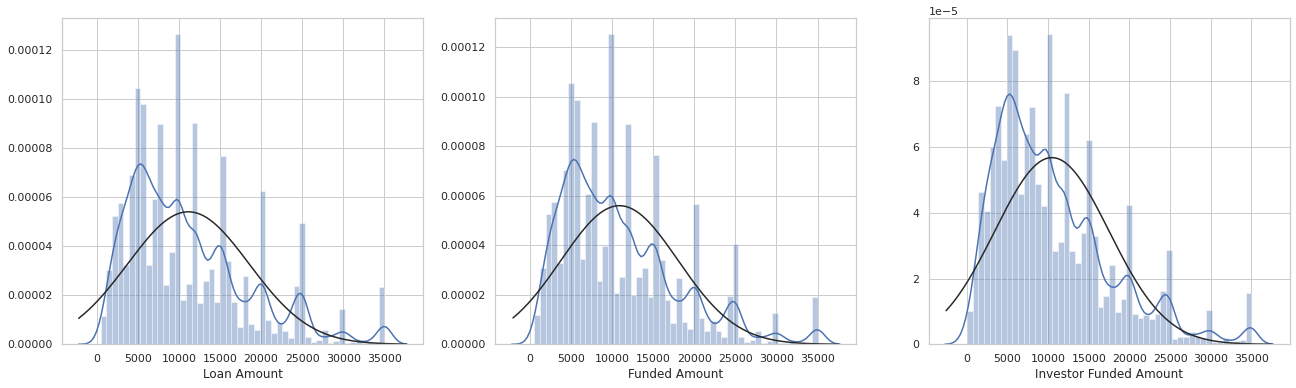

In [1668]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,3,1)
sns.distplot(loans.loan_amnt,fit = norm)
plt.xlabel('Loan Amount')
plt.subplot(1,3,2)
sns.distplot(loans.funded_amnt,fit = norm )
plt.xlabel('Funded Amount')
plt.subplot(1,3,3)
sns.distplot(loans.funded_amnt_inv,fit = norm)
plt.xlabel('Investor Funded Amount')
plt.show()

In [1669]:
loans =  loans[loans['loan_status'].isin(['Fully Paid','Charged Off'])]

### Loan Status

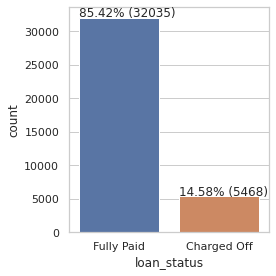

In [1670]:
plot_count_chart(loans.loan_status, (4,4))

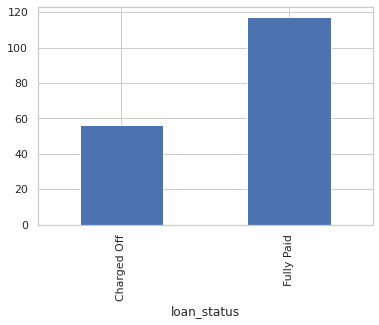

In [1671]:
#plot_count_chart((loans.groupby('loan_status').total_pymnt.sum() * 100 / loans.groupby('loan_status').loan_amnt.sum()), (4,4))

(loans.groupby('loan_status').total_pymnt.sum() * 100 / loans.groupby('loan_status').loan_amnt.sum()).plot.bar()
plt.xlabel('loan_status')
plt.show()


It can be observed that around 14% of loans are charged off<br>
Lending Club only recovers ~60% of the loan amount when loans are charged off. On fully paid up loans, the company makes ~20% profit.

### home_ownership

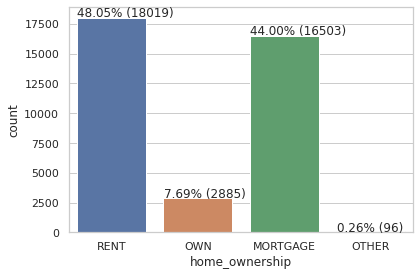

In [1672]:
plot_count_chart(loans.home_ownership, (6,4))

### purpose of loan

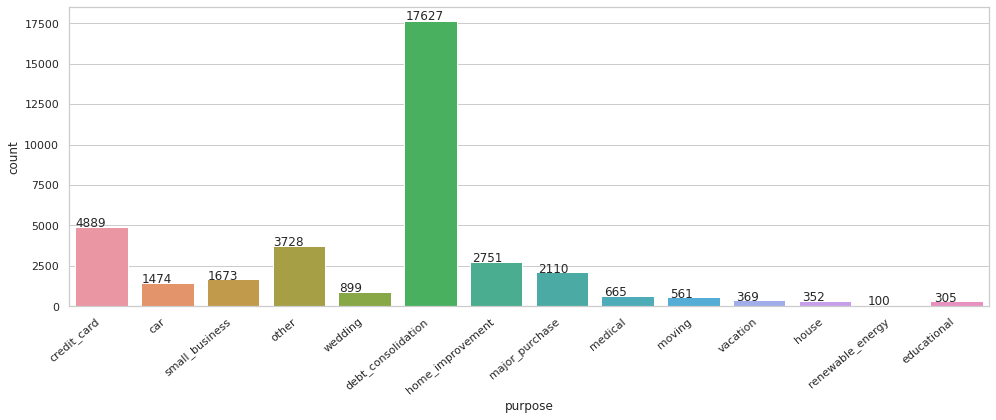

In [1673]:
plot_count_chart(loans.purpose, (14,6), isPercentage=False)

It can be observed that around 47% of the loans are taken for debt consolidation and the next highest being around ~13% is for credit card payments. So majorly loans are taken for existing debt's

TOP 5 Employee

In [1674]:
top5 = loans.emp_title.value_counts(normalize=False).head(10)
top5

Not Given            2302
US Army              129 
Bank of America      106 
IBM                  62  
AT&T                 57  
Kaiser Permanente    55  
Wells Fargo          52  
USAF                 52  
UPS                  52  
US Air Force         50  
Name: emp_title, dtype: int64

### verification status

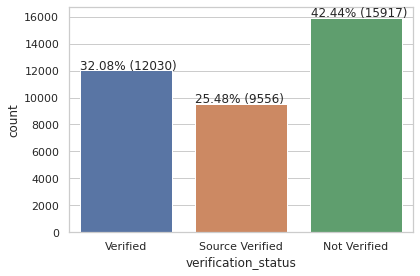

In [1675]:
plot_count_chart(loans.verification_status, (6,4))

Around 43% of loans are not verified

### Term

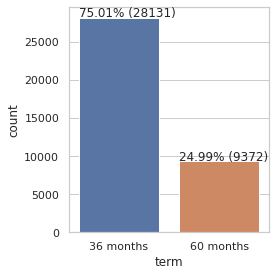

In [1676]:
plot_count_chart(loans.term, (4,4))

Around 75% of the loans are for 36 months. i.e many people take short term loans compared to long term loans

### delinq_2yrs

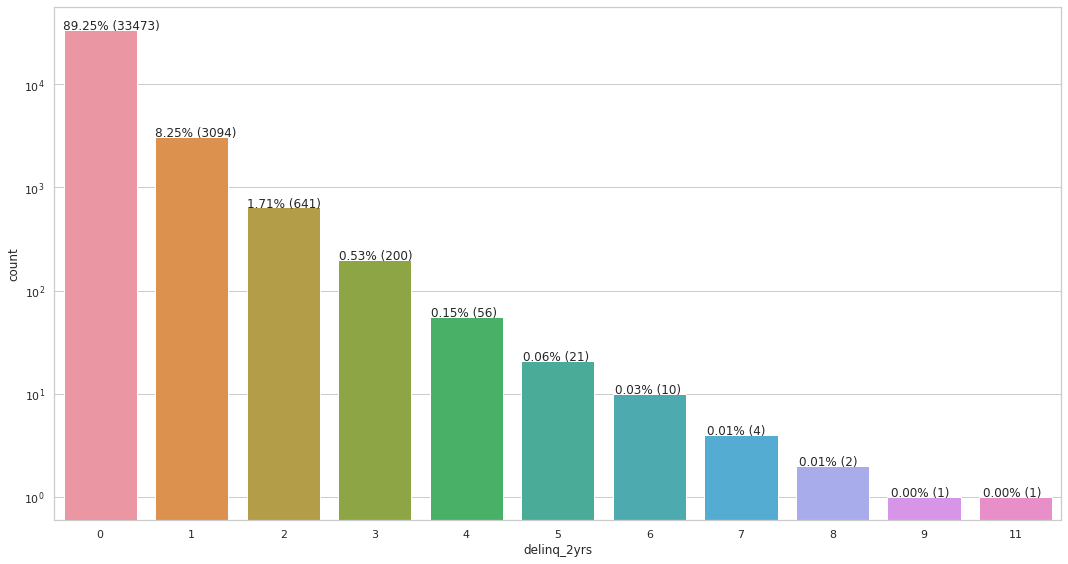

In [1677]:
plot_count_chart(loans.delinq_2yrs, figsize=(15,8), logScale=True)

People tend to have lesser number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

### Numbers of years of Experience

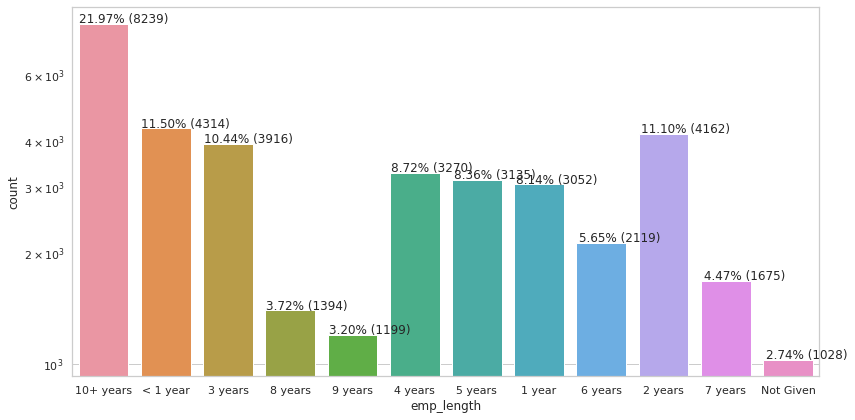

In [1678]:
plot_count_chart(loans.emp_length, logScale=True, figsize=(12,6))

People with 10+ years of experience take more loans.
The observation can be broken into 2 chunks, people with less than 4 years of experience and 10+ years of experience take more loans

### Grades of loan

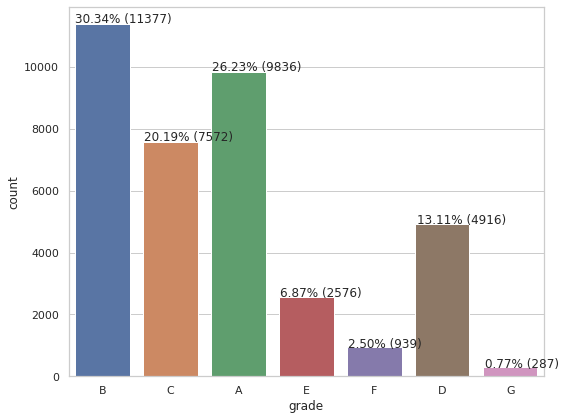

In [1679]:
plot_count_chart(loans.grade, figsize=(8, 6))

There are more lower grade loans

### no of inquires in last 6 months

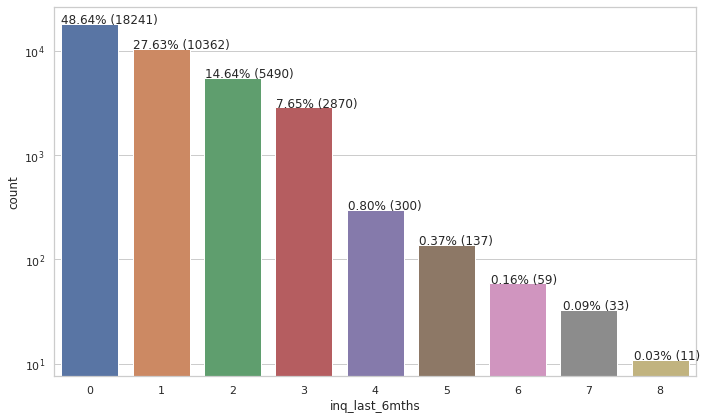

In [1680]:
plot_count_chart(loans.inq_last_6mths, logScale=True, figsize=(10,6))

### Months since last delinquency

## SEGMENTED UNIVARIATE & BIVARIATE ANALYSIS

###Region Analysis

In [1681]:
pd.crosstab([loans.addr_state],loans.loan_status,values=loans.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Fully Paid
addr_state,,
AK,0.184211,0.815789
AL,0.126761,0.873239
AR,0.116379,0.883621
AZ,0.146312,0.853688
CA,0.160735,0.839265
CO,0.126876,0.873124
CT,0.131054,0.868946
DC,0.067308,0.932692
DE,0.108108,0.891892


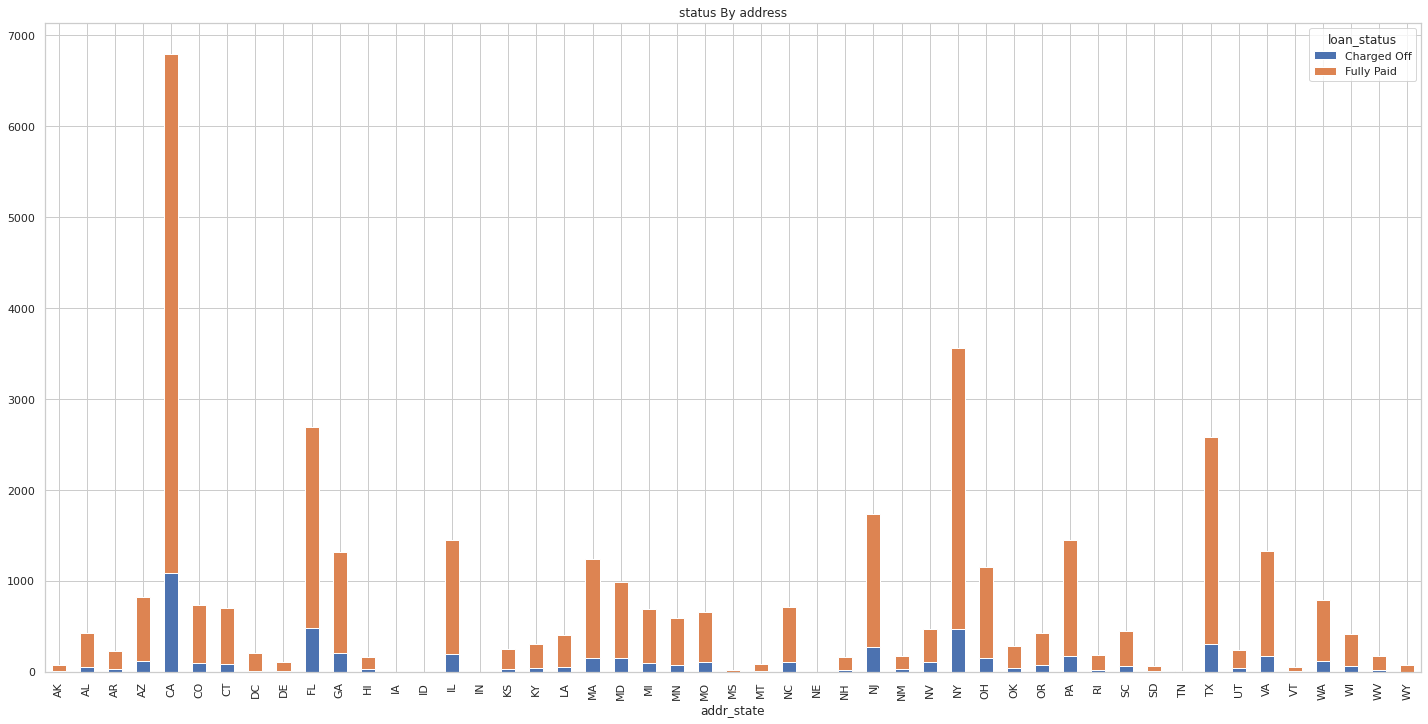

In [1682]:
bar_plot('addr_state', 'loan_status' ,title='status By address',data=loans, axistoggle= 'on',tabletoggle= False,sizerow= 20)

In [1683]:
#map states to regions
states = {
     'AK' :  'West' ,  'AL' :  'South' ,  'AR' :  'South' ,  'AZ' :  'West' ,  'CA' :  'West' ,  'CO' :  'West' ,  'CT' :  'Northeast' ,
       'DC' :  'South' ,  'DE' :  'South' ,  'FL' :  'South' ,  'GA' :  'South' ,  'HI' :  'West' ,  'IA' :  'Midwest' ,  'ID' :  'West' , 
        'IL' :  'Midwest' ,  'IN' :  'Midwest' ,  'KS' :  'Midwest' ,  'KY' :  'South' ,  'LA' :  'South' ,  'MA' :  'Northeast' ,  'MD' :  'South' , 
         'ME' :  'Northeast' ,  'MI' :  'Midwest' ,  'MN' :  'Midwest' ,  'MO' :  'Midwest' ,  'MS' :  'South' ,  'MT' :  'West' ,  'NC' :  'South' ,
          'ND' :  'Midwest' ,  'NE' :  'Midwest' ,  'NH' :  'Northeast' ,  'NJ' :  'Northeast' ,  'NM' :  'West' ,  'NV' :  'West' ,  'NY' :  'Northeast' , 
          'OH' :  'Midwest' ,  'OK' :  'South' ,  'OR' :  'West' ,  'PA' :  'Northeast' ,  'RI' :  'Northeast' ,  'SC' :  'South' ,  'SD' :  'Midwest' , 
          'TN' :  'South' ,  'TX' :  'South' ,  'UT' :  'West' ,  'VA' :  'South' ,  'VT' :  'Northeast' ,  'WA' :  'West' ,  'WI' :  'Midwest' , 
          'WV' :  'South' ,  'WY' :  'West' 
}
loans['Region']= loans['addr_state'].map(states)


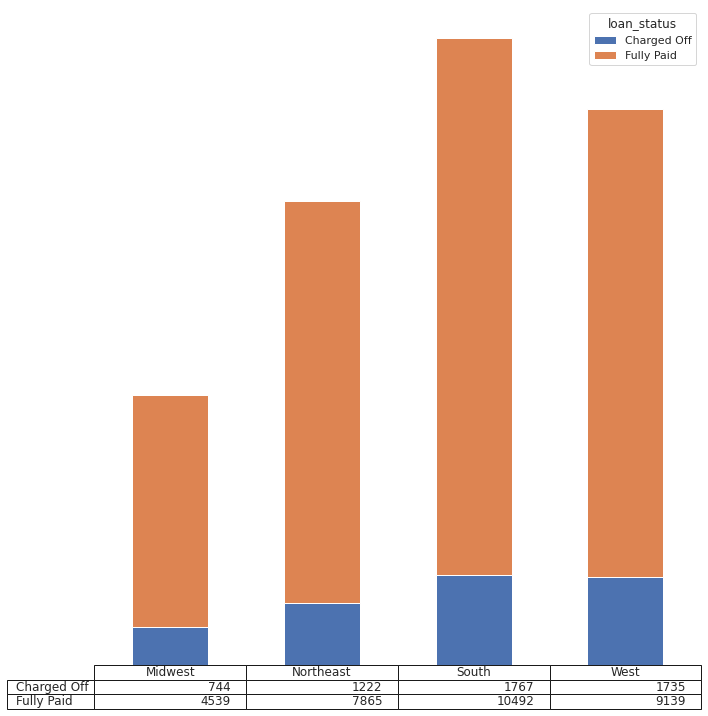

In [1684]:
bar_plot('Region' , 'loan_status', data=loans)


In [1685]:
pd.crosstab([loans.Region],loans.loan_status,values=loans.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Fully Paid
Region,,
Midwest,0.140829,0.859171
Northeast,0.134478,0.865522
South,0.144139,0.855861
West,0.159555,0.840445


Loans have been distributed predominantly to southern region . However ,western region has greater defaulted loans.

Now let us look at multiple factors with respect to loan status

### Verification Status vs Loan Status

In [1686]:
pd.crosstab(index=  [loans.verification_status],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
verification_status,,
Not Verified,0.126531,0.873469
Source Verified,0.148807,0.851193
Verified,0.168911,0.831089


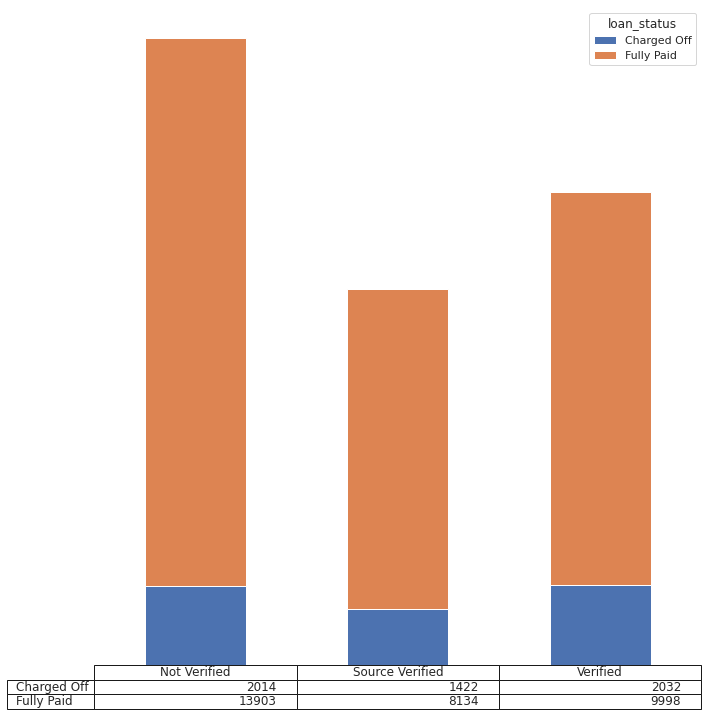

In [1687]:
bar_plot('verification_status' ,'loan_status', data=loans)

People who has verification status as verified are the ones with highest chances to be charged off

### Employment Length vs Loan Status

In [1688]:
pd.crosstab(index=  [loans.emp_length],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
emp_length,,
1 year,0.144495,0.855505
10+ years,0.156451,0.843549
2 years,0.132148,0.867852
3 years,0.139173,0.860827
4 years,0.135780,0.864220
5 years,0.144179,0.855821
6 years,0.141104,0.858896
7 years,0.153433,0.846567
8 years,0.143472,0.856528


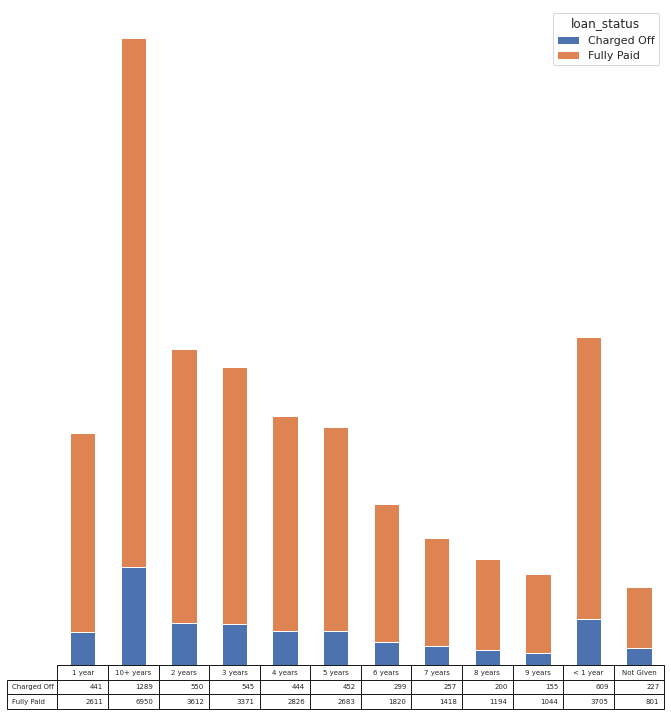

In [1689]:
bar_plot('emp_length' ,'loan_status', data=loans)

People who do not specify employment length have atleast 6% higher chances of not paying loan

### Grade vs Loan Status

In [1690]:
pd.crosstab(index=  [loans.grade],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
grade,,
A,0.060492,0.939508
B,0.121913,0.878087
C,0.172742,0.827258
D,0.219487,0.780513
E,0.269410,0.730590
F,0.325879,0.674121
G,0.344948,0.655052


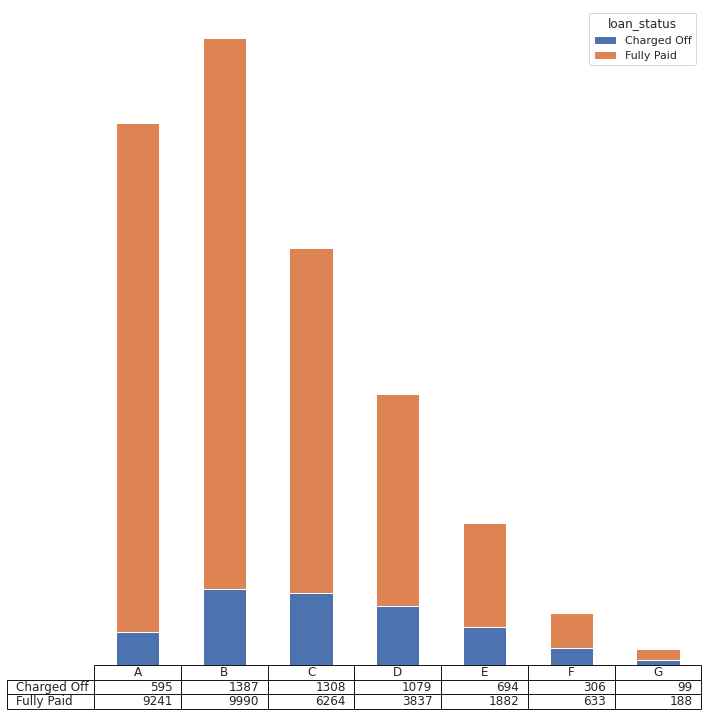

In [1691]:
bar_plot('grade','loan_status', data = loans)

In [1692]:
pd.crosstab(index=  [loans.sub_grade],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
sub_grade,,
A1,0.026762,0.973238
A2,0.049660,0.950340
A3,0.056818,0.943182
A4,0.062677,0.937323
A5,0.080797,0.919203
B1,0.094610,0.905390
B2,0.113120,0.886880
B3,0.120464,0.879536
B4,0.135124,0.864876


As the grade increases, chances of loan being charged off increases, same is observed with sub grade

### Home Ownership vs Loan Status

In [1693]:
pd.crosstab(index=  [loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,0.136824,0.863176
OTHER,0.187500,0.812500
OWN,0.148007,0.851993
RENT,0.153449,0.846551


People whoes home ownership status is other has higher chances of being charged off

### Loan Purpose vs Loan Status

In [1694]:
pd.crosstab(index=  [loans.purpose],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
purpose,,
car,0.106513,0.893487
credit_card,0.108202,0.891798
debt_consolidation,0.153231,0.846769
educational,0.170492,0.829508
home_improvement,0.119956,0.880044
house,0.161932,0.838068
major_purchase,0.102370,0.897630
medical,0.157895,0.842105
moving,0.156863,0.843137


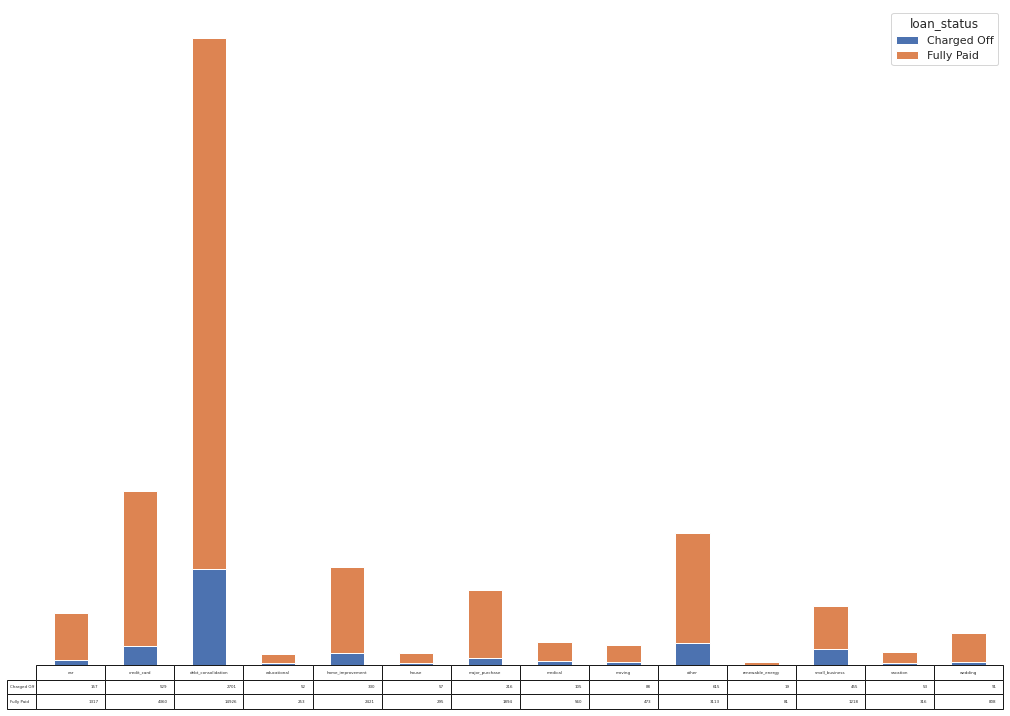

In [1695]:
bar_plot('purpose','loan_status', data = loans, sizerow=15, sizecolumn=10)

Loan's given to small business has around 26% chances of being charged off

### No Of Inquiry vs Loan Status

In [1696]:
pd.crosstab(index=  [loans.inq_last_6mths],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
inq_last_6mths,,
0,0.121978,0.878022
1,0.156727,0.843273
2,0.167031,0.832969
3,0.209059,0.790941
4,0.160000,0.840000
5,0.189781,0.810219
6,0.271186,0.728814
7,0.303030,0.696970
8,0.181818,0.818182


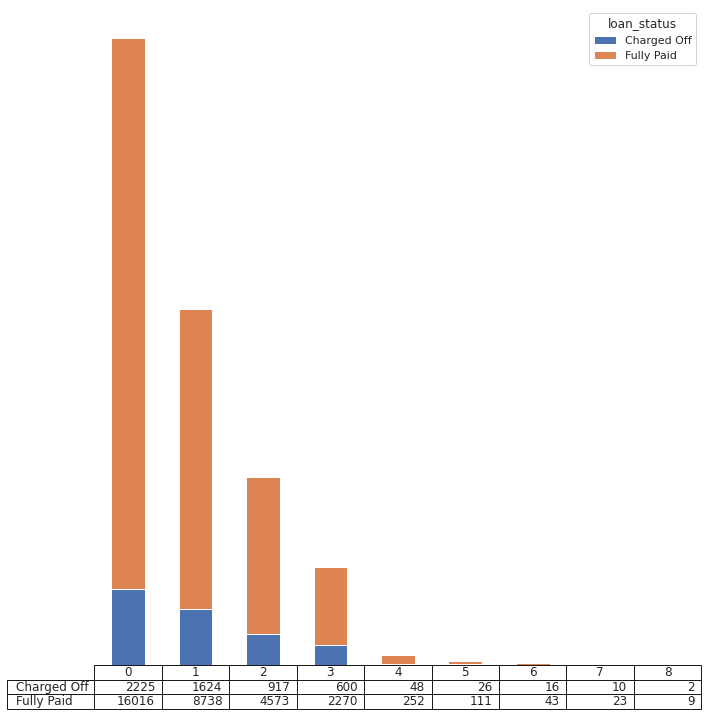

In [1697]:
bar_plot('inq_last_6mths','loan_status', data = loans)

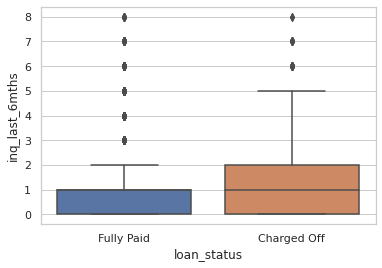

In [1698]:
sns.set(style="whitegrid")
sns.boxplot(y=loans.inq_last_6mths , x= loans.loan_status) 

People with number of inquiry greater than 4 will have more chances of loan being charged off, highest being at 7

### Derogatory public record vs Loan Status

In [1699]:
pd.crosstab(index=  [loans.pub_rec],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
pub_rec,,
0,0.141278,0.858722
1,0.225579,0.774421
2,0.217391,0.782609
3,0.000000,1.000000
4,0.000000,1.000000


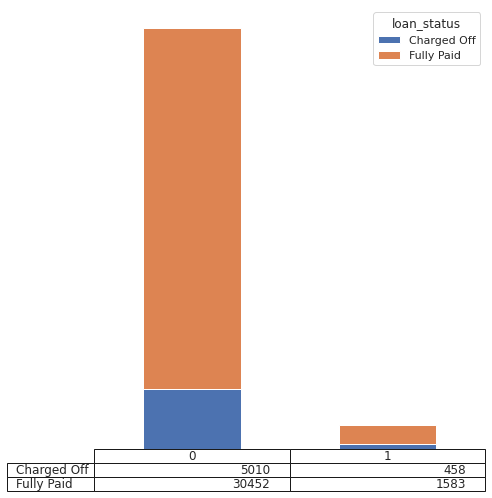

In [1700]:
loans['pub_rec_exists']= loans.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status',sizerow=7 , sizecolumn=7,data = loans)

People with more than one derogatory public record have more than 20% chances of loan being charged off

### Public record bankruptcies vs Loan Status

In [1701]:
pd.crosstab(index=  [loans.pub_rec_bankruptcies],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
pub_rec_bankruptcies,,
0.0,0.142228,0.857772
1.0,0.223515,0.776485
2.0,0.400000,0.600000


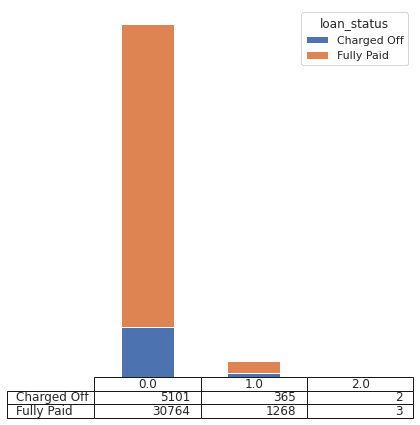

In [1702]:
bar_plot('pub_rec_bankruptcies' , 'loan_status',sizerow=6 , sizecolumn=6,data = loans)

People with atleast 1 public record bankruptcies have more than 20 % chances of loan being charged off <br>
"-1" indicates invalid values

### Interest Rate vs Loan Status

We will bucketize the interest rates first and then do the analysis

In [1703]:
loans.int_rate.quantile([0,0.25,0.5,0.75,1])

0.00    5.42 
0.25    8.94 
0.50    11.83
0.75    14.46
1.00    24.40
Name: int_rate, dtype: float64

In [1704]:
loans['interest_bin'] = pd.qcut(loans.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

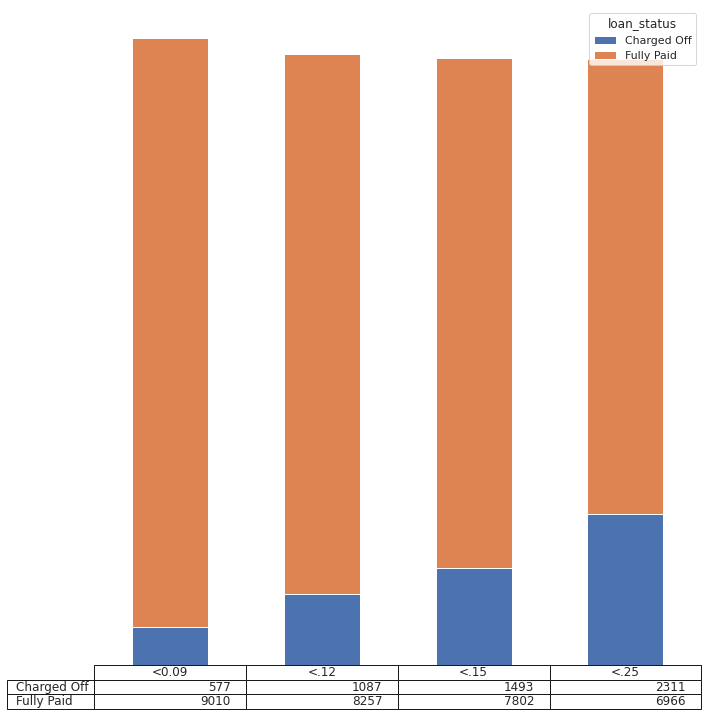

In [1705]:
bar_plot('interest_bin' ,'loan_status', data = loans)

In [1706]:
pd.crosstab([loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
interest_bin,,
<0.09,0.060186,0.939814
<.12,0.116331,0.883669
<.15,0.160624,0.839376
<.25,0.249111,0.750889


Higher the Interest rate, higher the chances of loan being charged off

### Loan Amount vs Loan Status

In [1707]:
loans.loan_amnt.describe()

count    37503.000000
mean     10981.874117
std      7281.200251 
min      500.000000  
25%      5225.000000 
50%      9600.000000 
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [1708]:

pd.crosstab(index=  [ pd.qcut(loans.loan_amnt, 4, labels=['<5200' , '<9600' , '<15000' , '<35000'],duplicates = 'drop')],
            columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
loan_amnt,,
<5200,0.139582,0.860418
<9600,0.127148,0.872852
<15000,0.135273,0.864727
<35000,0.187508,0.812492


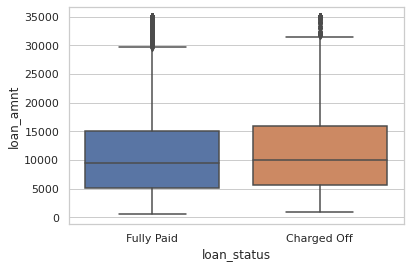

In [1709]:
sns.boxplot(y=loans.loan_amnt , x= loans.loan_status)

Higher the loan amount, higher the chances of loan being charged off

### Annual Income vs Loan Status

In [1710]:
loans.annual_inc.describe()

count    37503.000000 
mean     65362.418739 
std      35107.000280 
min      4000.000000  
25%      40000.000000 
50%      58000.000000 
75%      80400.000000 
max      234000.000000
Name: annual_inc, dtype: float64

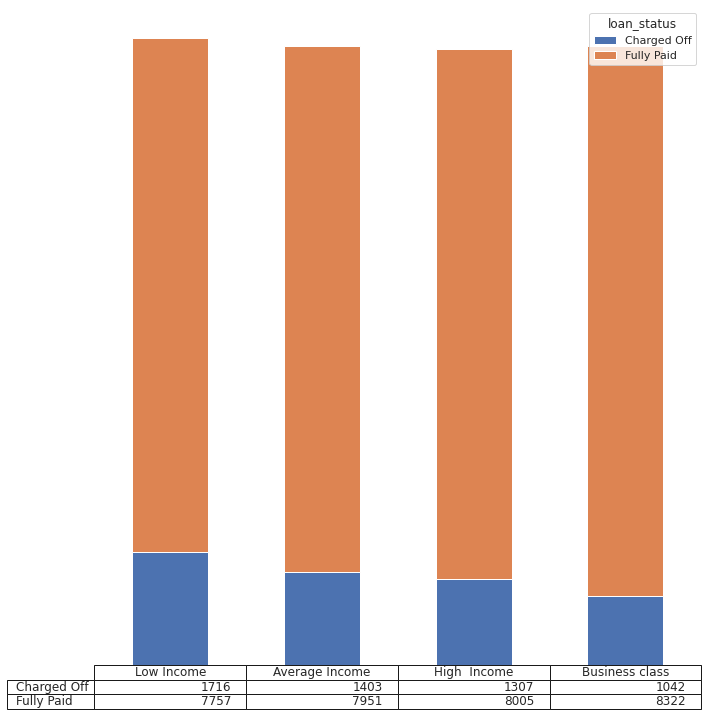

In [1711]:
loans['annual_inc_bin'] = pd.qcut(loans.annual_inc, 4, labels=['Low Income','Average Income','High  Income' ,'Business class'],duplicates = 'drop')
bar_plot(x='annual_inc_bin',y='loan_status' ,data = loans)

In [1712]:
pd.crosstab(index=  [loans.annual_inc_bin],
          columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count', normalize='index' )

loan_status,Charged Off,Fully Paid
annual_inc_bin,,
Low Income,0.181146,0.818854
Average Income,0.149989,0.850011
High Income,0.140357,0.859643
Business class,0.111277,0.888723


lower the annual income, higher the chances of loan being charged off.

### dti vs Loan Status

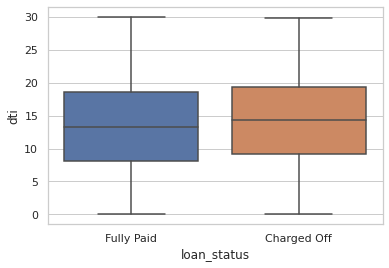

In [1713]:
sns.boxplot(y=loans.dti , x= loans.loan_status) 

In [1714]:
loans['dti_bin'] = pd.qcut(loans.dti, 4, labels=False,duplicates = 'drop')
pd.crosstab([loans.dti_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
dti_bin,,
0,0.124214,0.875786
1,0.137861,0.862139
2,0.154609,0.845391
3,0.166542,0.833458


dti seems to not have any impact on loan status

### CHECK ON FICO SCORE 

In [1715]:
loans['fico']=loans.desc.apply(lambda x : 1 if re.search('fico' ,x ) else 0 )

In [1716]:
pd.crosstab([loans.fico  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
fico,,
0,0.145678,0.854322
1,0.347826,0.652174


In [1717]:
loans_fico =loans[loans.fico == 1]
pd.crosstab([loans_fico.purpose  ],loans_fico.loan_status,values=loans_fico.loan_amnt,aggfunc='count',
           normalize='columns')

loan_status,Charged Off,Fully Paid
purpose,,
car,0.125,0.000000
credit_card,0.125,0.066667
debt_consolidation,0.750,0.533333
house,0.000,0.066667
major_purchase,0.000,0.066667
other,0.000,0.133333
small_business,0.000,0.133333


Higher chances of loan getting charged off if fico is mentioned on desc<br>
The cases where charged off is higher are mostly(~88%) debt consolidation/other when Fico is mentioned.

In [1718]:
loans['installment_ratio'] = (loans.installment *100)/(loans.annual_inc/12)

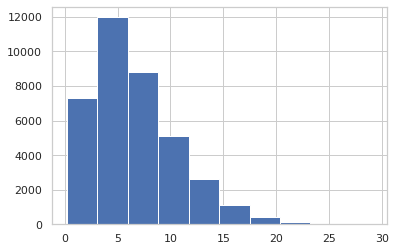

In [1719]:
loans.installment_ratio.hist()

In [1720]:
loans['high_installment_ratio'] = loans['installment_ratio'].apply(lambda x : 1 if x>8.9 else 0)


In [1721]:
pd.crosstab([loans.high_installment_ratio  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
high_installment_ratio,,
0,0.131331,0.868669
1,0.190120,0.809880


## DATA STORY 

WITH OUR UNDERSTANDING OF DATA , WE CAN NOW VENTURE INTO BUILDING STORY OR CONCLUDING OUR ANALYSIS 

In [1722]:
rs = np.random.RandomState(0)
cor = loans[['annual_inc','collection_recovery_fee','dti','inq_last_6mths','installment','last_pymnt_amnt','loan_amnt','open_acc','pub_rec','pub_rec_bankruptcies','revol_bal','revol_util','total_acc','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']].corr()
cor.style.background_gradient(cmap='coolwarm')

,annual_inc,collection_recovery_fee,dti,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
annual_inc,1.000000,0.022660,-0.108599,0.038530,0.415791,0.225795,0.417811,0.262739,-0.020511,-0.017156,0.421706,0.041417,0.379768,0.397655,0.386143,0.284208,0.017703,0.398753
collection_recovery_fee,0.022660,1.000000,0.011793,0.013160,0.077187,-0.043033,0.077215,0.006867,-0.005081,-0.005151,0.025259,0.028524,0.011030,0.027311,0.020608,0.041853,0.086676,-0.059197
dti,-0.108599,0.011793,1.000000,0.004986,0.061682,0.013151,0.071122,0.293625,-0.006073,0.005028,0.242835,0.278024,0.234734,0.067621,0.070033,0.108628,-0.010747,0.045386
inq_last_6mths,0.038530,0.013160,0.004986,1.000000,0.005327,0.025772,0.007921,0.093039,0.024408,0.016045,-0.023952,-0.068811,0.112832,-0.012310,-0.020037,0.025167,0.031248,-0.026105
installment,0.415791,0.077187,0.061682,0.005327,1.000000,0.413943,0.931260,0.170932,-0.044771,-0.031067,0.306227,0.095366,0.225370,0.857684,0.831431,0.642180,0.059689,0.846346
last_pymnt_amnt,0.225795,-0.043033,0.013151,0.025772,0.413943,1.000000,0.474825,0.082321,-0.032826,-0.022426,0.122115,-0.016004,0.165691,0.512776,0.502915,0.241944,-0.060666,0.569133
loan_amnt,0.417811,0.077215,0.071122,0.007921,0.931260,0.474825,1.000000,0.175786,-0.049456,-0.033995,0.311730,0.064508,0.251939,0.880856,0.857347,0.728155,0.049173,0.843904
open_acc,0.262739,0.006867,0.293625,0.093039,0.170932,0.082321,0.175786,1.000000,0.001563,0.007024,0.287455,-0.088529,0.685969,0.160815,0.153178,0.121223,-0.018072,0.159034
pub_rec,-0.020511,-0.005081,-0.006073,0.024408,-0.044771,-0.032826,-0.049456,0.001563,1.000000,0.847170,-0.060496,0.059332,-0.022566,-0.052368,-0.054859,-0.003465,-0.004138,-0.064084
pub_rec_bankruptcies,-0.017156,-0.005151,0.005028,0.016045,-0.031067,-0.022426,-0.033995,0.007024,0.847170,1.000000,-0.047157,0.061056,-0.009397,-0.041294,-0.044732,0.000504,-0.005664,-0.051589


Total amount recieved/principal/funded and amount seems to be highly correlated.We can have any 1 for our analysis .Lets retain Total amount and get rid of the rest.

In [1723]:
 loans.drop(['total_pymnt_inv','total_rec_prncp'],axis =1 ,inplace= True)

###Public Records/Bankrupcies/Interest/Late fee

LETS CHECK HOW A BALCKMARK ON OUR CUSTOMERS , INFLUENCE THEIR LOAN STATUS

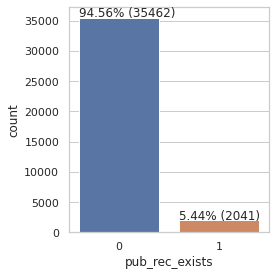

In [1724]:
plot_count_chart(loans.pub_rec_exists, (4,4))

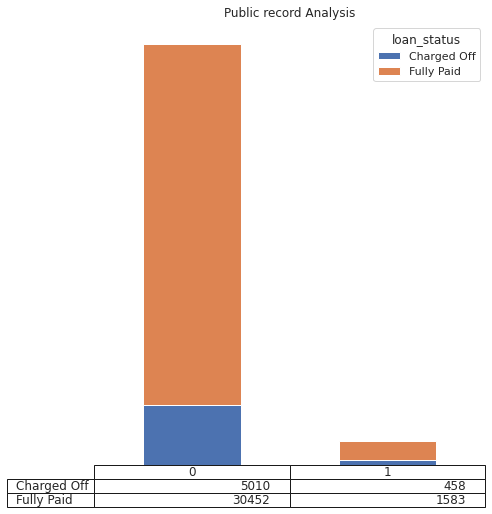

In [1725]:
loans['pub_rec_exists']= loans.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status',title = 'Public record Analysis', data=loans, sizerow=7 , sizecolumn=7)


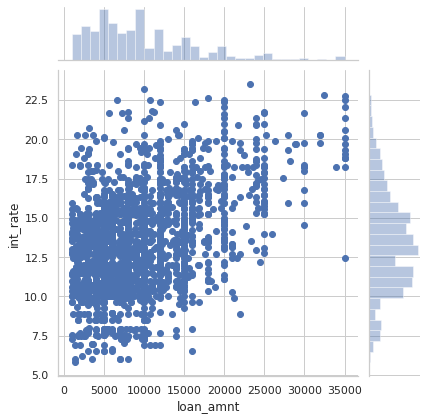

In [1726]:
sns.jointplot('loan_amnt', 'int_rate', loans.loc[loans.pub_rec_exists > 0])

In [1727]:
pd.crosstab([loans.pub_rec_exists],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
pub_rec_exists,,
0,0.141278,0.858722
1,0.224400,0.775600


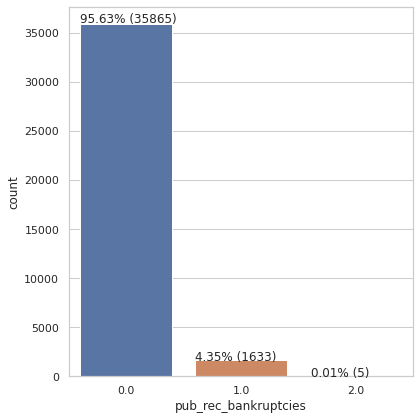

In [1728]:
plot_count_chart(loans.pub_rec_bankruptcies, (6,6))

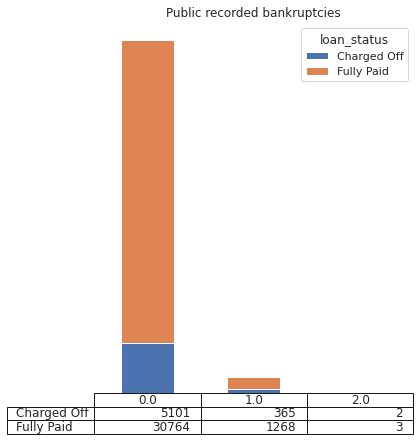

In [1729]:
bar_plot('pub_rec_bankruptcies' , 'loan_status', title = 'Public recorded bankruptcies',data=loans, sizerow=6 , sizecolumn=6)

In [1730]:
pd.crosstab([loans.pub_rec_bankruptcies ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
pub_rec_bankruptcies,,
0.0,0.142228,0.857772
1.0,0.223515,0.776485
2.0,0.400000,0.600000


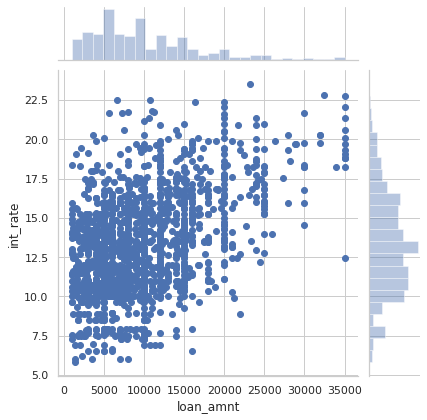

In [1731]:
sns.jointplot('loan_amnt', 'int_rate', loans.loc[loans.pub_rec_bankruptcies > 0])

In [1732]:
pd.crosstab([loans.pub_rec_bankruptcies ,loans.pub_rec_exists ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                          Charged Off  Fully Paid
pub_rec_bankruptcies pub_rec_exists                         
0.0                  0               0.141278     0.858722  
                     1               0.225806     0.774194  
1.0                  1               0.223515     0.776485  
2.0                  1               0.400000     0.600000

In [1733]:
pd.crosstab([loans.pub_rec_bankruptcies ,loans.pub_rec_exists ,
             loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                       Charged Off  Fully Paid
pub_rec_bankruptcies pub_rec_exists interest_bin                         
0.0                  0              <0.09         0.059746     0.940254  
                                    <.12          0.115263     0.884737  
                                    <.15          0.157110     0.842890  
                                    <.25          0.242272     0.757728  
                     1              <0.09         0.100000     0.900000  
                                    <.12          0.146341     0.853659  
                                    <.15          0.255474     0.744526  
                                    <.25          0.256098     0.743902  
1.0                  1              <0.09         0.086614     0.913386  
                                    <.12          0.130536     0.869464  
                                    <.15          0.195266     0.804734  
                                    <.25          0.349123     0.650877  
2.0                  1              <.12          1.000000     0.000000  
                                    <.15          0.000000     1.000000  
                                    <.25          0.333333     0.666667

The chances of loan charge off is higher if banrupsies are present , even where no bankrupsy , any public record will increase chances of loan getting wrtten off

In [1734]:
loans.total_rec_late_fee.describe()

count    37503.000000
mean     1.328443    
std      7.148500    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      0.000000    
max      180.200000  
Name: total_rec_late_fee, dtype: float64

In [1735]:
loans['late_fee_status'] = loans.total_rec_late_fee.apply(lambda c : 'Yes' if c>1 else 'No')

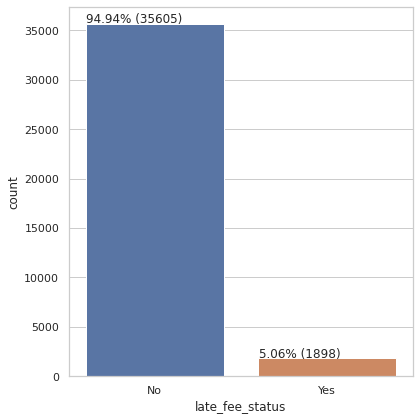

In [1736]:
plot_count_chart(loans.late_fee_status, (6,6))

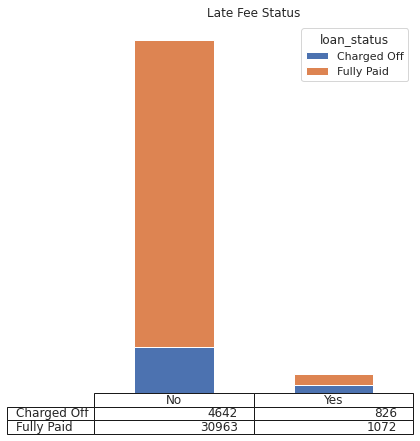

In [1737]:
bar_plot('late_fee_status' , 'loan_status', title = 'Late Fee Status', data=loans, sizerow=6 , sizecolumn=6)

In [1738]:
pd.crosstab([loans.late_fee_status ],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
late_fee_status,,
No,0.130375,0.869625
Yes,0.435195,0.564805


In [1739]:
pd.crosstab([loans.late_fee_status,loans.pub_rec_bankruptcies ,loans.pub_rec_exists ,
             loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                       Charged Off  \
late_fee_status pub_rec_bankruptcies pub_rec_exists interest_bin                
No              0.0                  0              <0.09         0.052740      
                                                    <.12          0.104865      
                                                    <.15          0.139901      
                                                    <.25          0.219060      
                                     1              <0.09         0.100000      
                                                    <.12          0.141026      
                                                    <.15          0.232558      
                                                    <.25          0.240000      
                1.0                  1              <0.09         0.080645      
                                                    <.12          0.119221      
                                                    <.15          0.182952      
                                                    <.25          0.336449      
                2.0                  1              <.12          1.000000      
                                                    <.15          0.000000      
                                                    <.25          0.500000      
Yes             0.0                  0              <0.09         0.346667      
                                                    <.12          0.357143      
                                                    <.15          0.420755      
                                                    <.25          0.514925      
                                     1              <.12          0.250000      
                                                    <.15          0.625000      
                                                    <.25          0.428571      
                1.0                  1              <0.09         0.333333      
                                                    <.12          0.388889      
                                                    <.15          0.423077      
                                                    <.25          0.542857      
                2.0                  1              <.25          0.000000      

loan_status                                                       Fully Paid  
late_fee_status pub_rec_bankruptcies pub_rec_exists interest_bin              
No              0.0                  0              <0.09         0.947260    
                                                    <.12          0.895135    
                                                    <.15          0.860099    
                                                    <.25          0.780940    
                                     1              <0.09         0.900000    
                                                    <.12          0.858974    
                                                    <.15          0.767442    
                                                    <.25          0.760000    
                1.0                  1              <0.09         0.919355    
                                                    <.12          0.880779    
                                                    <.15          0.817048    
                                                    <.25          0.663551    
                2.0                  1              <.12          0.000000    
                                                    <.15          1.000000    
                                                    <.25          0.500000    
Yes             0.0                  0              <0.09         0.653333    
                                                    <.12          0.642857    
                                                    <.15          0.579245    
                                                    <.25          0.48

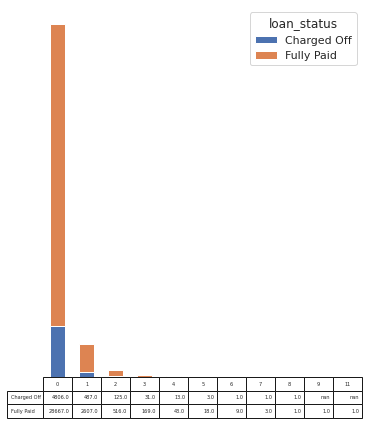

In [1740]:
bar_plot('delinq_2yrs' , 'loan_status',data=loans, sizerow=6 , sizecolumn=6)

In [1741]:
loans['delinq_status'] = loans.delinq_2yrs.apply(lambda c : 'Yes' if c>1 else 'No')

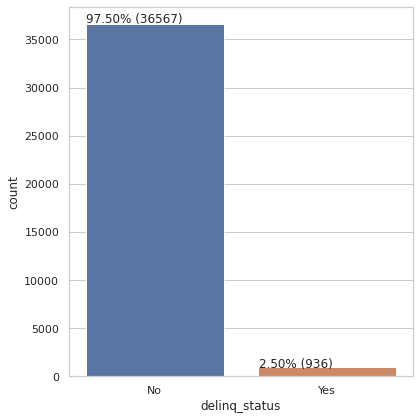

In [1742]:
plot_count_chart(loans.delinq_status, (6,6))

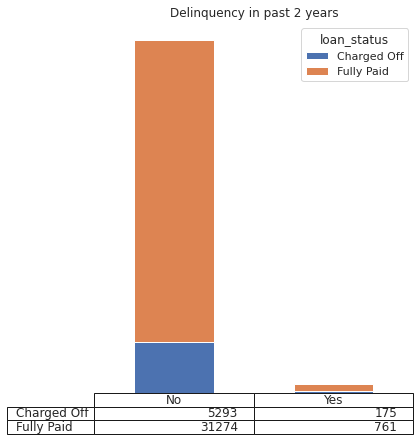

In [1743]:
bar_plot('delinq_status' , 'loan_status',title = 'Delinquency in past 2 years',data=loans, sizerow=6 , sizecolumn=6)

In [1744]:
pd.crosstab([loans.delinq_status],
            loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
delinq_status,,
No,0.144748,0.855252
Yes,0.186966,0.813034


In [1745]:
pd.crosstab([loans.delinq_status, loans.late_fee_status],
            loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                    Charged Off  Fully Paid
delinq_status late_fee_status                         
No            No               0.129683     0.870317  
              Yes              0.433536     0.566464  
Yes           No               0.158637     0.841363  
              Yes              0.470588     0.529412

In [1746]:
pd.crosstab([loans.delinq_status, loans.late_fee_status,
             loans.pub_rec_bankruptcies ,loans.pub_rec_exists ],
            loans.loan_status,values=loans.loan_amnt,aggfunc='count',normalize= 'index')


loan_status                                                        Charged Off  \
delinq_status late_fee_status pub_rec_bankruptcies pub_rec_exists                
No            No              0.0                  0               0.125004      
                                                   1               0.207084      
                              1.0                  1               0.211640      
                              2.0                  1               0.500000      
              Yes             0.0                  0               0.432670      
                                                   1               0.461538      
                              1.0                  1               0.448718      
                              2.0                  1               0.000000      
Yes           No              0.0                  0               0.155860      
                                                   1               0.300000      
                              1.0                  1               0.179487      
              Yes             0.0                  0               0.456790      
                              1.0                  1               0.750000      

loan_status                                                        Fully Paid  
delinq_status late_fee_status pub_rec_bankruptcies pub_rec_exists              
No            No              0.0                  0               0.874996    
                                                   1               0.792916    
                              1.0                  1               0.788360    
                              2.0                  1               0.500000    
              Yes             0.0                  0               0.567330    
                                                   1               0.538462    
                              1.0                  1               0.551282    
                              2.0                  1               1.000000    
Yes           No              0.0                  0               0.844140    
                                                   1               0.700000    
                              1.0                  1               0.820513    
              Yes             0.0                  0               0.543210    
                              1.0                  1               0.250000

When there are 2 or more offence , its best to avoid giving loan 

###Revol Util/Income/Open acoount/Interest

LETS SEE IF THE LENDER CAN MAKE ANY CHANGES TO THE TYPE OF LAON GIVEN BASED ON CUSTOMERS EXISTING FINANCIAL HEALTH/STATUS.

In [1747]:
loans.revol_util.describe()

count    37503.000000
mean     48.748716   
std      28.348751   
min     -1.000000    
25%      25.300000   
50%      49.200000   
75%      72.300000   
max      99.900000   
Name: revol_util, dtype: float64

In [1748]:
loans['Revol_util_bin'] = pd.qcut(loans.revol_util, 4, labels=['Low util','Average util','High  Util' ,'Max Util'],duplicates = 'drop')

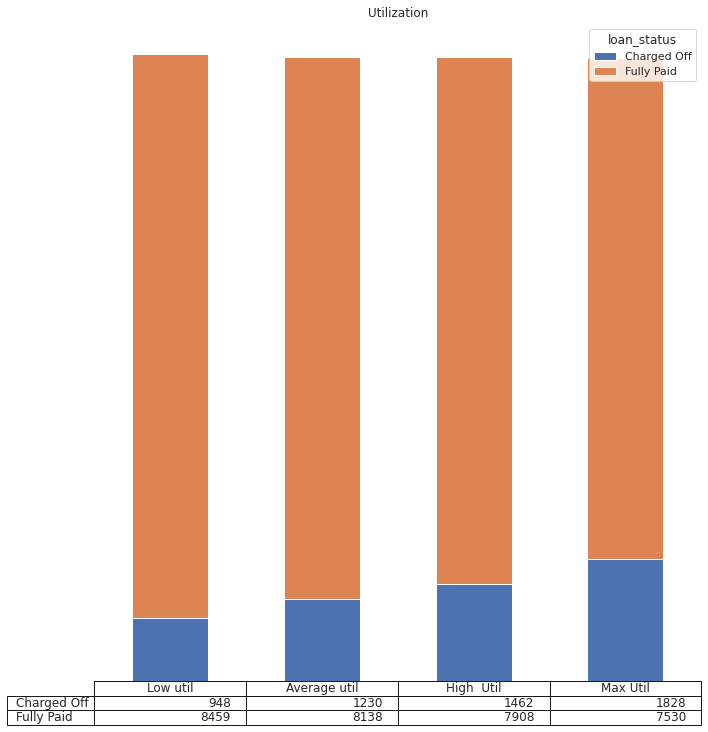

In [1749]:
bar_plot('Revol_util_bin' ,'loan_status',title = 'Utilization', data=loans )

In [1750]:
pd.crosstab([ loans.Revol_util_bin],loans.loan_status , 
            values= loans.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status,Charged Off,Fully Paid
Revol_util_bin,,
Low util,0.100776,0.899224
Average util,0.131298,0.868702
High Util,0.156030,0.843970
Max Util,0.195341,0.804659


In [1751]:
pd.crosstab([loans.term,loans.interest_bin , loans.Revol_util_bin],loans.loan_status , 
            values= loans.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                            Charged Off  Fully Paid
term      interest_bin Revol_util_bin                         
36 months <0.09        Low util        0.043349     0.956651  
                       Average util    0.060661     0.939339  
                       High  Util      0.086229     0.913771  
                       Max Util        0.093168     0.906832  
          <.12         Low util        0.087486     0.912514  
                       Average util    0.098129     0.901871  
                       High  Util      0.106393     0.893607  
                       Max Util        0.118999     0.881001  
          <.15         Low util        0.156757     0.843243  
                       Average util    0.134034     0.865966  
                       High  Util      0.126376     0.873624  
                       Max Util        0.141571     0.858429  
          <.25         Low util        0.213808     0.786192  
                       Average util    0.161184     0.838816  
                       High  Util      0.175676     0.824324  
                       Max Util        0.189492     0.810508  
60 months <0.09        Low util        0.074219     0.925781  
                       Average util    0.129032     0.870968  
                       High  Util      0.117647     0.882353  
                       Max Util        0.166667     0.833333  
          <.12         Low util        0.171806     0.828194  
                       Average util    0.173242     0.826758  
                       High  Util      0.182073     0.817927  
                       Max Util        0.211679     0.788321  
          <.15         Low util        0.195212     0.804788  
                       Average util    0.236417     0.763583  
                       High  Util      0.242057     0.757943  
                       Max Util        0.248837     0.751163  
          <.25         Low util        0.267666     0.732334  
                       Average util    0.295806     0.704194  
                       High  Util      0.291899     0.708101  
                       Max Util        0.332523     0.667477

In [1752]:
loans['open_acc_bin'] = pd.qcut(loans.open_acc, 4, labels=['2-6','7-9','10-12','13-44'], duplicates='drop')


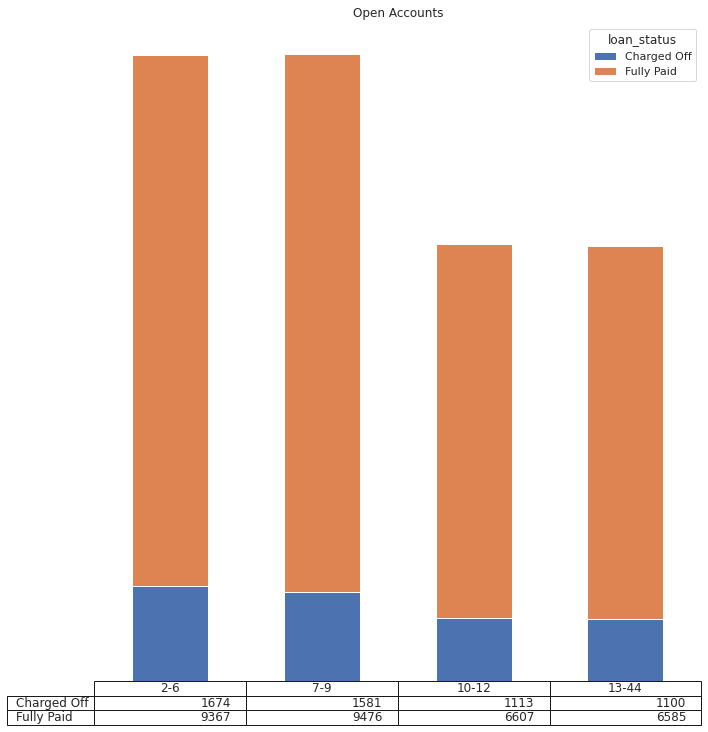

In [1753]:
bar_plot('open_acc_bin' ,'loan_status',title = 'Open Accounts', data=loans )

In [1754]:
pd.crosstab(loans.open_acc_bin,
            loans.loan_status , values= loans.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status,Charged Off,Fully Paid
open_acc_bin,,
2-6,0.151617,0.848383
7-9,0.142986,0.857014
10-12,0.144171,0.855829
13-44,0.143136,0.856864


In [1755]:
loans['loan_amnt_bin'] = pd.qcut(loans.loan_amnt, 4, labels=['<5200' , '<9600' , '<15000' , '<35000'],duplicates = 'drop')
loans_60 = loans[(loans.term == '60 months') & (loans.interest_bin.isin(['<.15','<.25']))]
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin],
            loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                  Charged Off  Fully Paid
interest_bin Revol_util_bin                         
<.15         Low util        0.195212     0.804788  
             Average util    0.236417     0.763583  
             High  Util      0.242057     0.757943  
             Max Util        0.248837     0.751163  
<.25         Low util        0.267666     0.732334  
             Average util    0.295806     0.704194  
             High  Util      0.291899     0.708101  
             Max Util        0.332523     0.667477

In [1756]:
loans.emp_length.value_counts()

10+ years    8239
< 1 year     4314
2 years      4162
3 years      3916
4 years      3270
5 years      3135
1 year       3052
6 years      2119
7 years      1675
8 years      1394
9 years      1199
Not Given    1028
Name: emp_length, dtype: int64

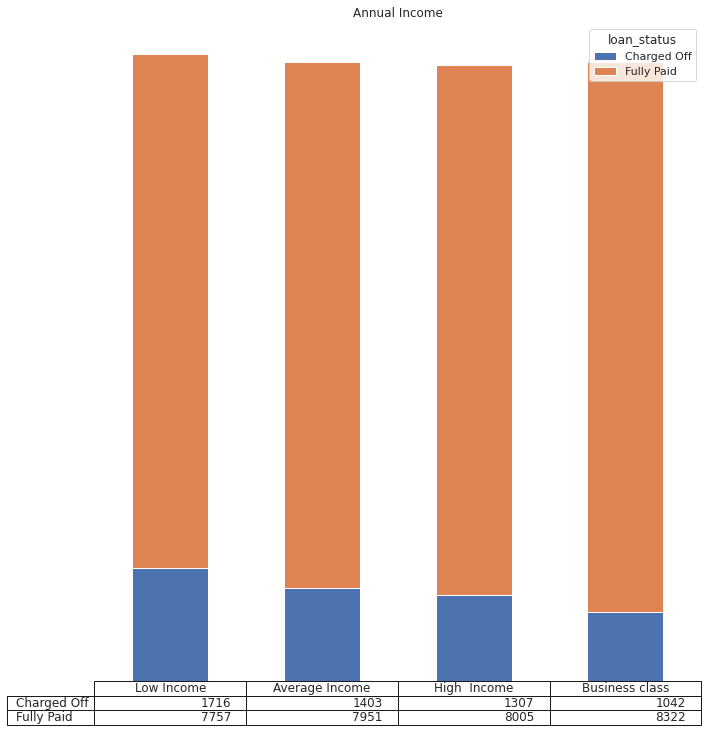

In [1757]:
bar_plot('annual_inc_bin' ,'loan_status',title = 'Annual Income', data=loans )

In [1758]:
pd.crosstab(loans.annual_inc_bin,
            loans.loan_status , values= loans.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status,Charged Off,Fully Paid
annual_inc_bin,,
Low Income,0.181146,0.818854
Average Income,0.149989,0.850011
High Income,0.140357,0.859643
Business class,0.111277,0.888723


In [1759]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin, loans_60.annual_inc_bin],
            loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                         
<.15         Low util       Low Income      0.327273     0.672727  
                            Average Income  0.212121     0.787879  
                            High  Income    0.152318     0.847682  
                            Business class  0.126667     0.873333  
             Average util   Low Income      0.321168     0.678832  
                            Average Income  0.257669     0.742331  
                            High  Income    0.251366     0.748634  
                            Business class  0.146465     0.853535  
             High  Util     Low Income      0.385714     0.614286  
                            Average Income  0.220126     0.779874  
                            High  Income    0.243094     0.756906  
                            Business class  0.149171     0.850829  
             Max Util       Low Income      0.351351     0.648649  
                            Average Income  0.315315     0.684685  
                            High  Income    0.162602     0.837398  
                            Business class  0.213115     0.786885  
<.25         Low util       Low Income      0.359649     0.640351  
                            Average Income  0.224490     0.775510  
                            High  Income    0.298387     0.701613  
                            Business class  0.190840     0.809160  
             Average util   Low Income      0.313187     0.686813  
                            Average Income  0.283721     0.716279  
                            High  Income    0.389610     0.610390  
                            Business class  0.215827     0.784173  
             High  Util     Low Income      0.317992     0.682008  
                            Average Income  0.321429     0.678571  
                            High  Income    0.297158     0.702842  
                            Business class  0.248869     0.751131  
             Max Util       Low Income      0.425595     0.574405  
                            Average Income  0.346614     0.653386  
                            High  Income    0.347826     0.652174  
                            Business class  0.262369     0.737631

In [1760]:
loans_60 = loans_60[loans_60.Revol_util_bin >'Average util']
loans_60.shape

(4580, 55)

In [1761]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                         
<.15         High  Util     Low Income      0.385714     0.614286  
                            Average Income  0.220126     0.779874  
                            High  Income    0.243094     0.756906  
                            Business class  0.149171     0.850829  
             Max Util       Low Income      0.351351     0.648649  
                            Average Income  0.315315     0.684685  
                            High  Income    0.162602     0.837398  
                            Business class  0.213115     0.786885  
<.25         High  Util     Low Income      0.317992     0.682008  
                            Average Income  0.321429     0.678571  
                            High  Income    0.297158     0.702842  
                            Business class  0.248869     0.751131  
             Max Util       Low Income      0.425595     0.574405  
                            Average Income  0.346614     0.653386  
                            High  Income    0.347826     0.652174  
                            Business class  0.262369     0.737631

In [1762]:
loans_60 = loans_60[loans_60.annual_inc_bin < 'High  Income']

In [1763]:
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                 Charged Off  Fully Paid
interest_bin Revol_util_bin annual_inc_bin                         
<.15         High  Util     Low Income      0.385714     0.614286  
                            Average Income  0.220126     0.779874  
             Max Util       Low Income      0.351351     0.648649  
                            Average Income  0.315315     0.684685  
<.25         High  Util     Low Income      0.317992     0.682008  
                            Average Income  0.321429     0.678571  
             Max Util       Low Income      0.425595     0.574405  
                            Average Income  0.346614     0.653386

In [1764]:
loans_60.open_acc_bin.unique()

[7-9, 13-44, 2-6, 10-12]
Categories (4, object): [2-6 < 7-9 < 10-12 < 13-44]

In [1765]:
loans_60 = loans_60[loans_60.annual_inc_bin == 'Low Income']
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin,loans_60.open_acc_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')#.to_excel('Loans.xlsx')

loan_status                                              Charged Off  \
interest_bin Revol_util_bin annual_inc_bin open_acc_bin                
<.15         High  Util     Low Income     2-6           0.333333      
                                           7-9           0.437500      
                                           10-12         0.500000      
                                           13-44         0.266667      
             Max Util       Low Income     2-6           0.325581      
                                           7-9           0.450000      
                                           10-12         0.125000      
                                           13-44         0.666667      
<.25         High  Util     Low Income     2-6           0.313131      
                                           7-9           0.283784      
                                           10-12         0.319149      
                                           13-44         0.473684      
             Max Util       Low Income     2-6           0.383838      
                                           7-9           0.423529      
                                           10-12         0.571429      
                                           13-44         0.611111      

loan_status                                              Fully Paid  
interest_bin Revol_util_bin annual_inc_bin open_acc_bin              
<.15         High  Util     Low Income     2-6           0.666667    
                                           7-9           0.562500    
                                           10-12         0.500000    
                                           13-44         0.733333    
             Max Util       Low Income     2-6           0.674419    
                                           7-9           0.550000    
                                           10-12         0.875000    
                                           13-44         0.333333    
<.25         High  Util     Low Income     2-6           0.686869    
                                           7-9           0.716216    
                                           10-12         0.680851    
                                           13-44         0.526316    
             Max Util       Low Income     2-6           0.616162    
                                           7-9           0.576471    
                                           10-12         0.428571    
                                           13-44         0.388889

In [1806]:
#loans_60 = loans_60[loans_60.open_acc > 9]
pd.crosstab([loans_60.interest_bin , loans_60.Revol_util_bin,
             loans_60.annual_inc_bin,loans_60.loan_amnt_bin],loans_60.loan_status , values= loans_60.loan_amnt , aggfunc= 'count',normalize= 'index')

loan_status                                               Charged Off  \
interest_bin Revol_util_bin annual_inc_bin loan_amnt_bin                
<.15         High  Util     Low Income     <5200          0.297297      
                                           <9600          0.303030      
                                           <15000         0.477273      
                                           <35000         0.461538      
             Max Util       Low Income     <5200          0.235294      
                                           <9600          0.461538      
                                           <15000         0.333333      
                                           <35000         0.285714      
<.25         High  Util     Low Income     <5200          0.262295      
                                           <9600          0.369231      
                                           <15000         0.333333      
                                           <35000         0.292683      
             Max Util       Low Income     <5200          0.400000      
                                           <9600          0.368421      
                                           <15000         0.491935      
                                           <35000         0.404762      

loan_status                                               Fully Paid  
interest_bin Revol_util_bin annual_inc_bin loan_amnt_bin              
<.15         High  Util     Low Income     <5200          0.702703    
                                           <9600          0.696970    
                                           <15000         0.522727    
                                           <35000         0.538462    
             Max Util       Low Income     <5200          0.764706    
                                           <9600          0.538462    
                                           <15000         0.666667    
                                           <35000         0.714286    
<.25         High  Util     Low Income     <5200          0.737705    
                                           <9600          0.630769    
                                           <15000         0.666667    
                                           <35000         0.707317    
             Max Util       Low Income     <5200          0.600000    
                                           <9600          0.631579    
                                           <15000         0.508065    
                                           <35000         0.595238

###Income/Interest Rates/Employee length/Grade

INSTALLMENT TO *INCOME* RATIO ANALYSIS

In [1767]:
loans['installment_ratio'] = (loans.installment *100)/(loans.annual_inc/12)

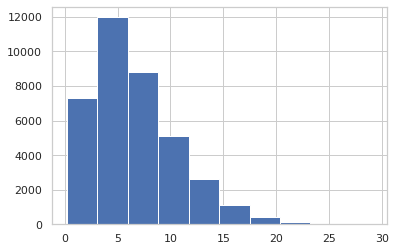

In [1768]:
loans.installment_ratio.hist()

In [1769]:
loans['installment_ratio'].describe()


count    37503.000000
mean     6.591541    
std      3.971043    
min      0.194700    
25%      3.558771    
50%      5.812000    
75%      8.837927    
max      29.016500   
Name: installment_ratio, dtype: float64

Categorizing values above 75th percentile as high installment values

In [1770]:
quan = loans['installment_ratio'].quantile([0.75]).to_list()[0]
loans['high_installment_ratio'] = loans['installment_ratio'].apply(lambda x : True if x>quan else False)


In [1771]:
pd.crosstab([loans.high_installment_ratio  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
high_installment_ratio,,
False,0.131226,0.868774
True,0.189526,0.810474


Lets check how employess income influences the payment of loan taken.

In [1772]:
pd.crosstab([loans.loan_amnt_bin ],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Fully Paid
loan_amnt_bin,,
<5200,0.139582,0.860418
<9600,0.127148,0.872852
<15000,0.135273,0.864727
<35000,0.187508,0.812492


In [1773]:
pd.crosstab([loans.loan_amnt_bin ,loans.annual_inc_bin],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                   Charged Off  Fully Paid
loan_amnt_bin annual_inc_bin                         
<5200         Low Income      0.164074     0.835926  
              Average Income  0.142215     0.857785  
              High  Income    0.117165     0.882835  
              Business class  0.077477     0.922523  
<9600         Low Income      0.172321     0.827679  
              Average Income  0.118929     0.881071  
              High  Income    0.103774     0.896226  
              Business class  0.090582     0.909418  
<15000        Low Income      0.210338     0.789662  
              Average Income  0.135936     0.864064  
              High  Income    0.129955     0.870045  
              Business class  0.087020     0.912980  
<35000        Low Income      0.273364     0.726636  
              Average Income  0.241153     0.758847  
              High  Income    0.201372     0.798628  
              Business class  0.147558     0.852442

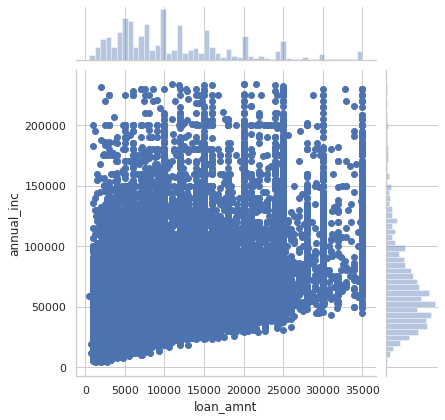

In [1774]:
sns.jointplot('loan_amnt', 'annual_inc', loans)

In [1775]:
pd.crosstab([loans.loan_amnt_bin ,loans.annual_inc_bin],loans.loan_status,
            values=loans.loan_amnt,aggfunc='count')

loan_status                   Charged Off  Fully Paid
loan_amnt_bin annual_inc_bin                         
<5200         Low Income      675          3439      
              Average Income  348          2099      
              High  Income    200          1507      
              Business class  86           1024      
<9600         Low Income      513          2464      
              Average Income  311          2304      
              High  Income    231          1995      
              Business class  151          1516      
<15000        Low Income      411          1543      
              Average Income  376          2390      
              High  Income    377          2524      
              Business class  240          2518      
<35000        Low Income      117          311       
              Average Income  368          1158      
              High  Income    499          1979      
              Business class  565          3264

Binning Interest rates into quartiles

In [1776]:
loans.int_rate.quantile([0.25,0.5,0.75,1])

0.25    8.94 
0.50    11.83
0.75    14.46
1.00    24.40
Name: int_rate, dtype: float64

In [1777]:
loans['interest_bin'] = pd.qcut(loans.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

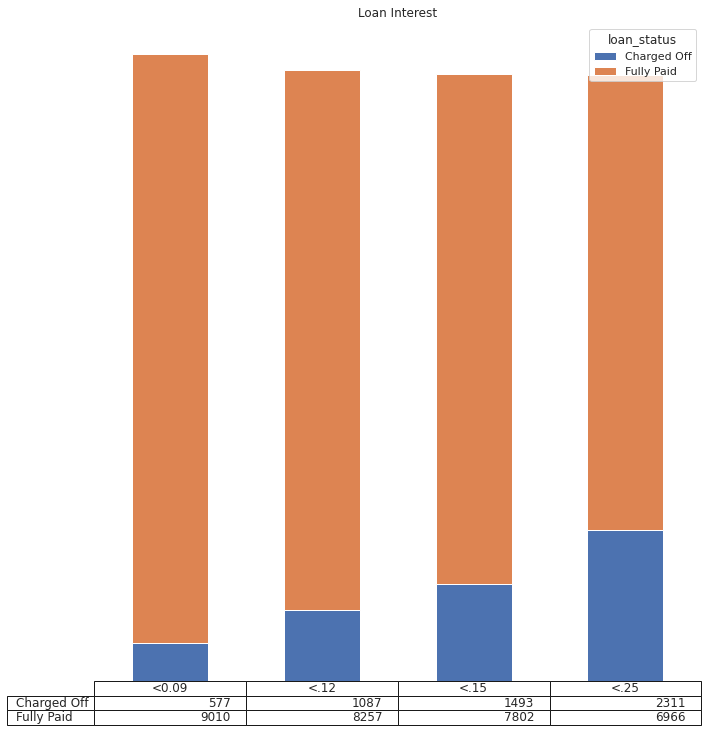

In [1778]:
bar_plot('interest_bin' ,'loan_status',title = 'Loan Interest', data=loans)

In [1779]:
pd.crosstab([loans.interest_bin],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
interest_bin,,
<0.09,0.060186,0.939814
<.12,0.116331,0.883669
<.15,0.160624,0.839376
<.25,0.249111,0.750889


As the interest rates grow higher the chances of charging off  the loan increases.

In [1780]:
pd.crosstab([loans.emp_length  ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
emp_length,,
1 year,0.144495,0.855505
10+ years,0.156451,0.843549
2 years,0.132148,0.867852
3 years,0.139173,0.860827
4 years,0.135780,0.864220
5 years,0.144179,0.855821
6 years,0.141104,0.858896
7 years,0.153433,0.846567
8 years,0.143472,0.856528


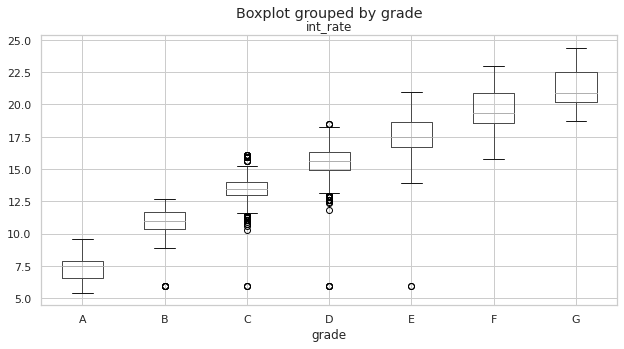

In [1781]:
fig, ax = plt.subplots(figsize=(10,5))
loans.boxplot(column=['int_rate'],by='grade', ax=ax)
plt.show()

In [1782]:
pd.crosstab([loans.emp_length , loans.interest_bin ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status              Charged Off  Fully Paid
emp_length interest_bin                         
1 year     <0.09         0.063704     0.936296  
           <.12          0.137405     0.862595  
           <.15          0.131792     0.868208  
           <.25          0.242424     0.757576  
10+ years  <0.09         0.062472     0.937528  
           <.12          0.114787     0.885213  
           <.15          0.175612     0.824388  
           <.25          0.276465     0.723535  
2 years    <0.09         0.050936     0.949064  
           <.12          0.096715     0.903285  
           <.15          0.151431     0.848569  
           <.25          0.226249     0.773751  
3 years    <0.09         0.058702     0.941298  
           <.12          0.095522     0.904478  
           <.15          0.163836     0.836164  
           <.25          0.242812     0.757188  
4 years    <0.09         0.050063     0.949937  
           <.12          0.120907     0.879093  
           <.15          0.125622     0.874378  
           <.25          0.237113     0.762887  
5 years    <0.09         0.058603     0.941397  
           <.12          0.115237     0.884763  
           <.15          0.162667     0.837333  
           <.25          0.240648     0.759352  
6 years    <0.09         0.052536     0.947464  
           <.12          0.100775     0.899225  
           <.15          0.160156     0.839844  
           <.25          0.252319     0.747681  
7 years    <0.09         0.043584     0.956416  
           <.12          0.129808     0.870192  
           <.15          0.176755     0.823245  
           <.25          0.258661     0.741339  
8 years    <0.09         0.051680     0.948320  
           <.12          0.122754     0.877246  
           <.15          0.167647     0.832353  
           <.25          0.246246     0.753754  
9 years    <0.09         0.061162     0.938838  
           <.12          0.096990     0.903010  
           <.15          0.150183     0.849817  
           <.25          0.216667     0.783333  
< 1 year   <0.09         0.063927     0.936073  
           <.12          0.122526     0.877474  
           <.15          0.151801     0.848199  
           <.25          0.233871     0.766129  
Not Given  <0.09         0.116456     0.883544  
           <.12          0.214559     0.785441  
           <.15          0.360947     0.639053  
           <.25          0.315271     0.684729

In [1783]:
pd.crosstab([loans.grade , loans.interest_bin ],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status         Charged Off  Fully Paid
grade interest_bin                         
A     <0.09         0.059380     0.940620  
      <.12          0.085308     0.914692  
B     <0.09         0.109756     0.890244  
      <.12          0.116086     0.883914  
      <.15          0.143737     0.856263  
C     <0.09         0.000000     1.000000  
      <.12          0.222222     0.777778  
      <.15          0.164579     0.835421  
      <.25          0.216554     0.783446  
D     <0.09         0.000000     1.000000  
      <.15          0.194030     0.805970  
      <.25          0.222372     0.777628  
E     <0.09         0.000000     1.000000  
      <.15          0.200000     0.800000  
      <.25          0.269755     0.730245  
F     <.25          0.325879     0.674121  
G     <.25          0.344948     0.655052

In [1784]:
loans.open_acc.describe()

count    37503.000000
mean     9.254700    
std      4.373255    
min      2.000000    
25%      6.000000    
50%      9.000000    
75%      12.000000   
max      44.000000   
Name: open_acc, dtype: float64

In [1785]:
loans.open_acc.quantile([0, .25,.50,0.75 ,1])

0.00    2.0 
0.25    6.0 
0.50    9.0 
0.75    12.0
1.00    44.0
Name: open_acc, dtype: float64

In [1786]:
loans['open_acc_bin'] = pd.qcut(loans.open_acc, 4, labels=['2-6','7-9','10-12','13-44'],duplicates = 'drop')

In [1787]:
loans.groupby('open_acc_bin')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
open_acc_bin,,,,,,,,
2-6,11041.0,4.725025,1.202924,2.0,4.0,5.0,6.0,6.0
7-9,11057.0,7.973320,0.814082,7.0,7.0,8.0,9.0,9.0
10-12,7720.0,10.886788,0.807326,10.0,10.0,11.0,12.0,12.0
13-44,7685.0,15.966558,3.174731,13.0,14.0,15.0,17.0,44.0


In [1788]:
loans.open_acc_bin.unique()

[2-6, 10-12, 7-9, 13-44]
Categories (4, object): [2-6 < 7-9 < 10-12 < 13-44]

###Check Grade/Subgrade/Term

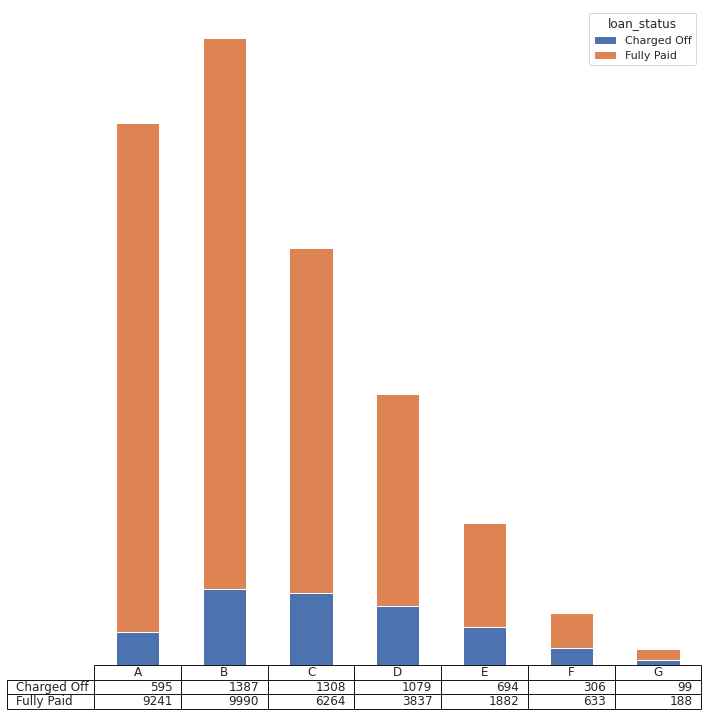

In [1789]:
bar_plot('grade','loan_status', data=loans)

In [1790]:
pd.crosstab(index = [loans.grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Fully Paid
grade,,
A,0.060492,0.939508
B,0.121913,0.878087
C,0.172742,0.827258
D,0.219487,0.780513
E,0.269410,0.730590
F,0.325879,0.674121
G,0.344948,0.655052


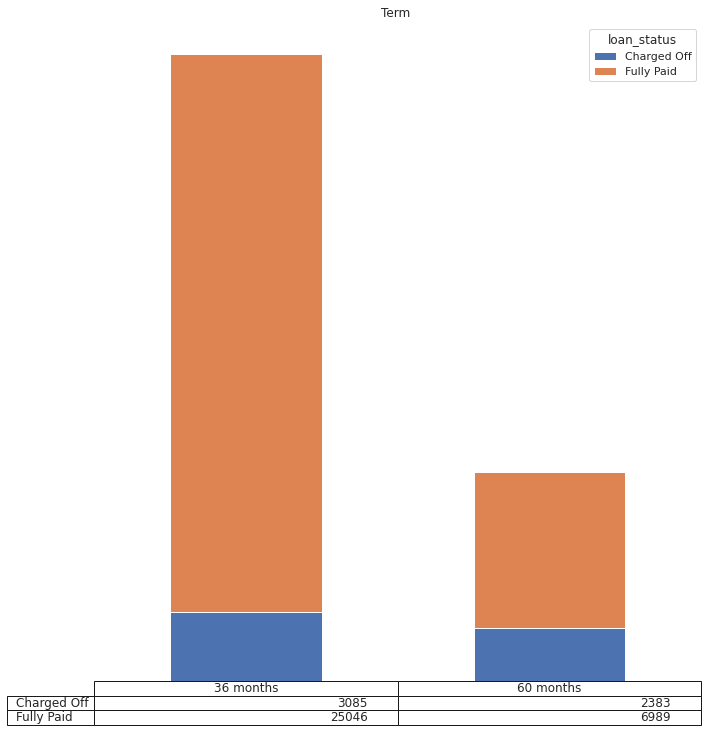

In [1791]:
bar_plot('term','loan_status', title = 'Term ',data=loans)

In [1792]:
pd.crosstab(index = [loans.term ] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Fully Paid
term,,
36 months,0.109665,0.890335
60 months,0.254268,0.745732


In [1793]:
pd.crosstab(index = [loans.term ,loans.grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status      Charged Off  Fully Paid
term      grade                         
36 months A      0.059091     0.940909  
          B      0.104832     0.895168  
          C      0.146616     0.853384  
          D      0.176585     0.823415  
          E      0.198529     0.801471  
          F      0.242105     0.757895  
          G      0.377358     0.622642  
60 months A      0.094148     0.905852  
          B      0.188089     0.811911  
          C      0.242601     0.757399  
          D      0.291146     0.708854  
          E      0.302273     0.697727  
          F      0.347130     0.652870  
          G      0.337607     0.662393

In [1794]:


pd.crosstab(index = [loans.term ,loans.grade,loans.sub_grade] , columns = loans.loan_status , values = loans.loan_amnt, aggfunc = 'count' , normalize= 'index')
#.stack().reset_index().rename(columns={0:'value'})


loan_status                Charged Off  Fully Paid
term      grade sub_grade                         
36 months A     A1         0.026762     0.973238  
                A2         0.049451     0.950549  
                A3         0.057592     0.942408  
                A4         0.061021     0.938979  
                A5         0.078592     0.921408  
          B     B1         0.088761     0.911239  
                B2         0.098193     0.901807  
                B3         0.106103     0.893897  
                B4         0.112118     0.887882  
                B5         0.115565     0.884435  
          C     C1         0.133903     0.866097  
                C2         0.139445     0.860555  
                C3         0.159656     0.840344  
                C4         0.148026     0.851974  
                C5         0.160987     0.839013  
          D     D1         0.176871     0.823129  
                D2         0.171171     0.828829  
                D3         0.189769     0.810231  
                D4         0.172786     0.827214  
                D5         0.170029     0.829971  
          E     E1         0.216912     0.783088  
                E2         0.205000     0.795000  
                E3         0.150943     0.849057  
                E4         0.183673     0.816327  
                E5         0.229885     0.770115  
          F     F1         0.218182     0.781818  
                F2         0.250000     0.750000  
                F3         0.214286     0.785714  
                F4         0.176471     0.823529  
                F5         0.400000     0.600000  
          G     G1         0.157895     0.842105  
                G2         0.333333     0.666667  
                G3         1.000000     0.000000  
                G4         0.333333     0.666667  
                G5         0.666667     0.333333  
60 months A     A2         0.071429     0.928571  
                A3         0.024390     0.975610  
                A4         0.100000     0.900000  
                A5         0.105505     0.894495  
          B     B1         0.146067     0.853933  
                B2         0.202899     0.797101  
                B3         0.169329     0.830671  
                B4         0.200972     0.799028  
                B5         0.199372     0.800628  
          C     C1         0.232236     0.767764  
                C2         0.229846     0.770154  
                C3         0.249357     0.750643  
                C4         0.277778     0.722222  
                C5         0.250000     0.750000  
          D     D1         0.384615     0.615385  
                D2         0.269807     0.730193  
                D3         0.277311     0.722689  
                D4         0.300000     0.700000  
                D5         0.316129     0.683871  
          E     E1         0.308585     0.691415  
                E2         0.293671     0.706329  
                E3         0.268222     0.731778  
                E4         0.338658     0.661342  
                E5         0.305755     0.694245  
          F     F1         0.307054     0.692946  
                F2         0.314607     0.685393  
                F3         0.306569     0.693431  
                F4         0.414414     0.585586  
                F5         0.512195     0.487805  
          G     G1         0.388889     0.611111  
                G2         0.370968     0.629032  
                G3         0.375000     0.625000  
                G4         0.214286     0.785714  
                G5         0.222222     0.777778

###Home Ownership ,Verification Status and Term

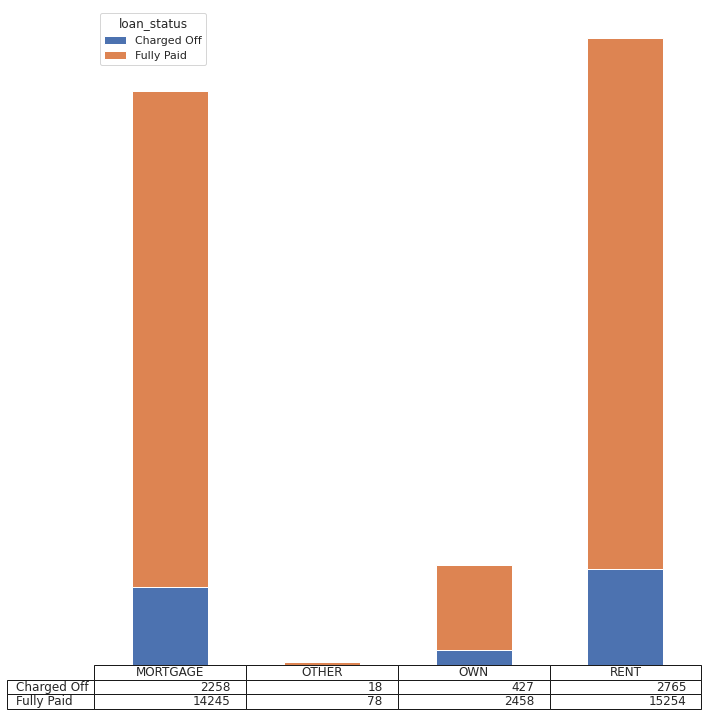

In [1795]:
bar_plot('home_ownership','loan_status',data = loans)

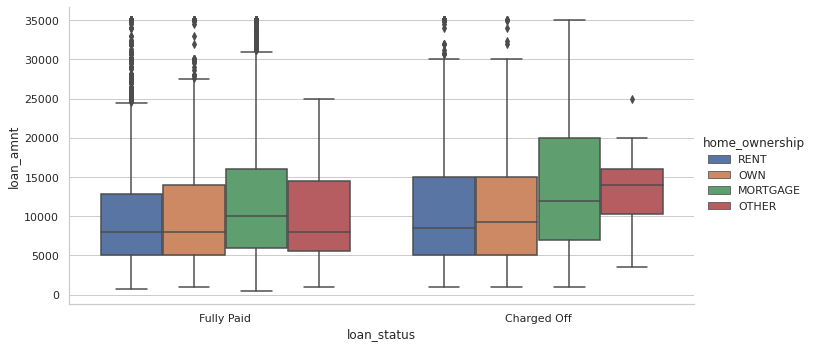

In [1796]:
sns.catplot(x="loan_status", y="loan_amnt", hue="home_ownership", kind="box", data=loans,height=5, aspect=2)

In [1797]:
pd.crosstab(index=  [loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,0.136824,0.863176
OTHER,0.187500,0.812500
OWN,0.148007,0.851993
RENT,0.153449,0.846551


In [1798]:
pd.crosstab(index=  [loans.term,loans.home_ownership],columns = loans.loan_status, values= loans.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status               Charged Off  Fully Paid
term      home_ownership                         
36 months MORTGAGE        0.097145     0.902855  
          OTHER           0.178947     0.821053  
          OWN             0.106901     0.893099  
          RENT            0.119784     0.880216  
60 months MORTGAGE        0.229618     0.770382  
          OTHER           1.000000     0.000000  
          OWN             0.284431     0.715569  
          RENT            0.281117     0.718883

In [1799]:
pd.crosstab(index= [loans.verification_status,loans.home_ownership,loans.term ] ,
            columns= [loans.loan_status] , values= loans.loan_amnt ,aggfunc= 'count',normalize= 'index')

loan_status                                   Charged Off  Fully Paid
verification_status home_ownership term                              
Not Verified        MORTGAGE       36 months  0.098959     0.901041  
                                   60 months  0.216049     0.783951  
                    OTHER          36 months  0.176471     0.823529  
                                   60 months  1.000000     0.000000  
                    OWN            36 months  0.109016     0.890984  
                                   60 months  0.239766     0.760234  
                    RENT           36 months  0.120143     0.879857  
                                   60 months  0.234067     0.765933  
Source Verified     MORTGAGE       36 months  0.080975     0.919025  
                                   60 months  0.230449     0.769551  
                    OTHER          36 months  0.100000     0.900000  
                    OWN            36 months  0.093690     0.906310  
                                   60 months  0.312796     0.687204  
                    RENT           36 months  0.119317     0.880683  
                                   60 months  0.292625     0.707375  
Verified            MORTGAGE       36 months  0.105962     0.894038  
                                   60 months  0.235136     0.764864  
                    OTHER          36 months  0.205882     0.794118  
                    OWN            36 months  0.116034     0.883966  
                                   60 months  0.290210     0.709790  
                    RENT           36 months  0.119572     0.880428  
                                   60 months  0.297066     0.702934

###Purpose/Term

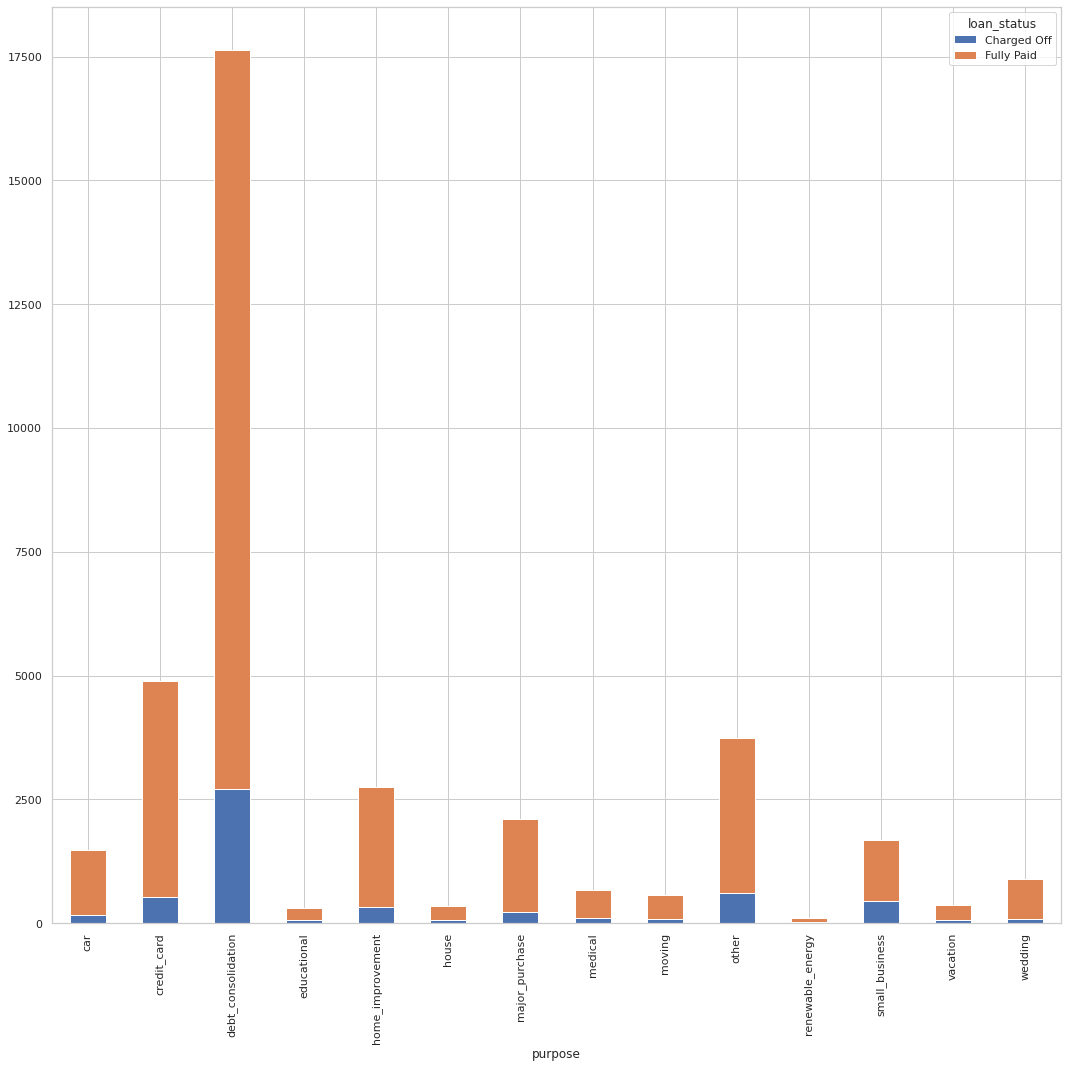

In [1800]:
bar_plot('purpose', 'loan_status',data=loans, tabletoggle= False,sizecolumn= 15 , sizerow= 15,axistoggle= 'on')

In [1801]:
pd.crosstab([loans.purpose],loans.loan_status,values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Fully Paid
purpose,,
car,0.106513,0.893487
credit_card,0.108202,0.891798
debt_consolidation,0.153231,0.846769
educational,0.170492,0.829508
home_improvement,0.119956,0.880044
house,0.161932,0.838068
major_purchase,0.102370,0.897630
medical,0.157895,0.842105
moving,0.156863,0.843137


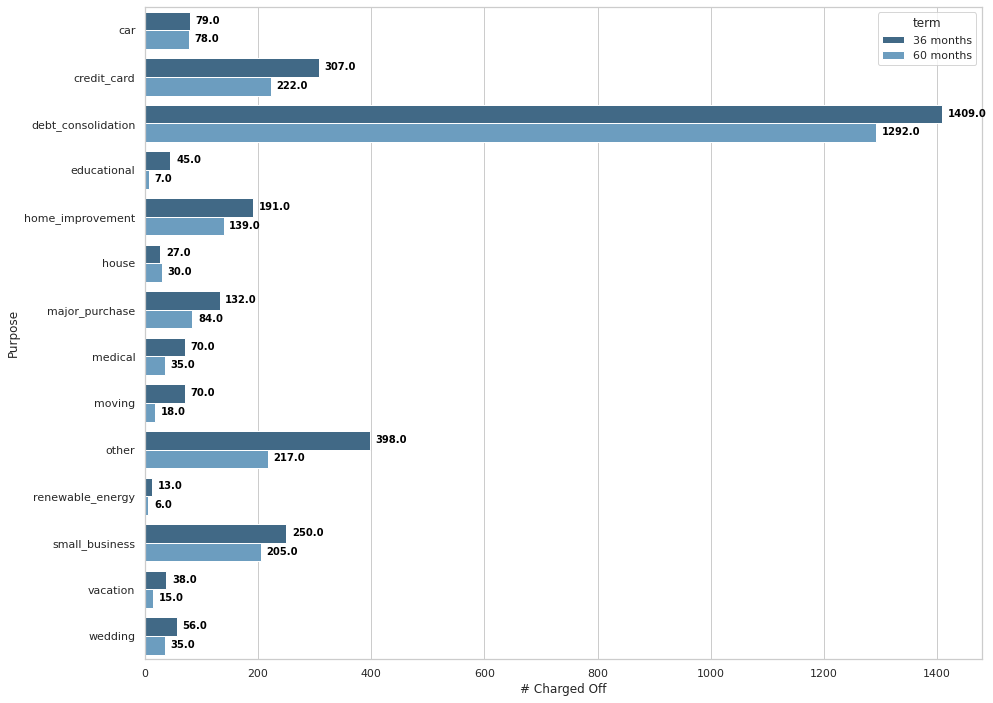

In [1802]:
loans_d= pd.crosstab([loans.purpose ,loans.term ],[loans.loan_status],
                     values=loans.loan_amnt,aggfunc='count').reset_index().fillna(0)
fig, ax = plt.subplots(figsize=(15,12))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Charged Off' ,y ='purpose',data =  loans_d ,hue = 
            'term' ,palette= 'Blues_d').set(
                xlabel ='# Charged Off' , ylabel= 'Purpose')
#to get values next to bar plots(THIS WILL THROW WARNINGS , WHICH IS IGNORED)
for i in ax.patches:
    ax.text(i.get_width()+10, i.get_y()+0.25, str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='black')
plt.show()


In [1803]:
pd.crosstab([loans.purpose ,loans.term ],[loans.loan_status],values=loans.loan_amnt,aggfunc='count',
           normalize='index')

loan_status                   Charged Off  Fully Paid
purpose            term                              
car                36 months  0.081950     0.918050  
                   60 months  0.152941     0.847059  
credit_card        36 months  0.077545     0.922455  
                   60 months  0.238710     0.761290  
debt_consolidation 36 months  0.110484     0.889516  
                   60 months  0.265080     0.734920  
educational        36 months  0.155709     0.844291  
                   60 months  0.437500     0.562500  
home_improvement   36 months  0.096954     0.903046  
                   60 months  0.177977     0.822023  
house              36 months  0.108000     0.892000  
                   60 months  0.294118     0.705882  
major_purchase     36 months  0.078107     0.921893  
                   60 months  0.200000     0.800000  
medical            36 months  0.136452     0.863548  
                   60 months  0.230263     0.769737  
moving             36 months  0.148936     0.851064  
                   60 months  0.197802     0.802198  
other              36 months  0.132182     0.867818  
                   60 months  0.302650     0.697350  
renewable_energy   36 months  0.173333     0.826667  
                   60 months  0.240000     0.760000  
small_business     36 months  0.214225     0.785775  
                   60 months  0.405138     0.594862  
vacation           36 months  0.120635     0.879365  
                   60 months  0.277778     0.722222  
wedding            36 months  0.079433     0.920567  
                   60 months  0.180412     0.819588

In [1804]:
#df.verification_status,df.home_ownership,
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.crosstab([loans.verification_status,loans.purpose ,loans.term ],[loans.loan_status],values=loans.loan_amnt,aggfunc='count',
           normalize='index')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


loan_status                                       Charged Off  Fully Paid
verification_status purpose            term                              
Not Verified        car                36 months  0.066790     0.933210  
                                       60 months  0.123932     0.876068  
                    credit_card        36 months  0.077164     0.922836  
                                       60 months  0.209091     0.790909  
                    debt_consolidation 36 months  0.110961     0.889039  
                                       60 months  0.235474     0.764526  
                    educational        36 months  0.145000     0.855000  
                                       60 months  0.600000     0.400000  
                    home_improvement   36 months  0.103590     0.896410  
                                       60 months  0.179775     0.820225  
                    house              36 months  0.128440     0.871560  
                                       60 months  0.409091     0.590909  
                    major_purchase     36 months  0.082222     0.917778  
                                       60 months  0.162393     0.837607  
                    medical            36 months  0.155102     0.844898  
                                       60 months  0.224490     0.775510  
                    moving             36 months  0.123762     0.876238  
                                       60 months  0.192308     0.807692  
                    other              36 months  0.139835     0.860165  
                                       60 months  0.291667     0.708333  
                    renewable_energy   36 months  0.181818     0.818182  
                                       60 months  0.750000     0.250000  
                    small_business     36 months  0.215356     0.784644  
                                       60 months  0.442623     0.557377  
                    vacation           36 months  0.129252     0.870748  
                                       60 months  0.263158     0.736842  
                    wedding            36 months  0.077399     0.922601  
                                       60 months  0.093750     0.906250  
Source Verified     car                36 months  0.080153     0.919847  
                                       60 months  0.168539     0.831461  
                    credit_card        36 months  0.081590     0.918410  
                                       60 months  0.277512     0.722488  
                    debt_consolidation 36 months  0.104992     0.895008  
                                       60 months  0.271186     0.728814  
                    educational        36 months  0.107143     0.892857  
                                       60 months  0.250000     0.750000  
                    home_improvement   36 months  0.094092     0.905908  
                                       60 months  0.197425     0.802575  
                    house              36 months  0.132353     0.867647  
                                       60 months  0.375000     0.625000  
                    major_purchase     36 months  0.065909     0.934091  
                                       60 months  0.251748     0.748252  
                    medical            36 months  0.114865     0.885135  
                                       60 months  0.245283     0.754717  
                    moving             36 months  0.205882     0.794118  
                                       60 months  0.264706     0.735294  
                    other              36 months  0.117130     0.882870  
                                       60 months  0.327189     0.672811  
                    renewable_energy   36 months  0.107143     0.892857  
                                       60 months  0.100000     0.900000  
                    small_business     36 months  0.185185     0.814815  
                                       60 months  0.373563     0.626437  
    

Long term loans for vacation , education ,small business ,credit card or for no reasons is a bad idea